In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [6]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [7]:
DECODER_ATT = "scse"

#### head

In [8]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [9]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [10]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [11]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [12]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [13]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [14]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [15]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [16]:
perceptual_ext = PerceptualLoss()

In [17]:
sobel_filter = Sobel().to(device)

In [18]:
def train_d_epoch(epoch, generator, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update True/Fake D network
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())

        tf_dis = 0
        for _y_cls, _y_pr_cls in \
            zip(y_cls, y_pr_cls):
            B, C = _y_cls.size()
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                            tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(EPOCH + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (2) Update Edge D network
        ###########################        
        edge_d_optim.zero_grad()        
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in \
            zip(edge_y_cls, edge_pr_cls):
            B, C = _edge_y_cls.size()
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(EPOCH + index / iteration)

        edge_dis_l += edge_dis.item()


    return  edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [19]:
def train_g_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, edge_discriminator, 
                    dataloader, device):
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    mae_l = 0
    tf_gen_l = 0
    edge_gen_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        ############################
        # (1) Update G network: maximize log(D(G(z)))
        ###########################
        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        assert y_pr.requires_grad, "ct_pred without gradient"
        
        gen_optim.zero_grad()

        # adversarial loss
        y_pr_cls = tf_discriminator(y_pr)
        
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            B, C = _y_pr_cls.size()
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        

        edge_y_pr = sobel_filter(y_pr)
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            B, C = _edge_pr_cls.size()
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) +\
                                    edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        
        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  mae_l/(index+1), air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1)

In [20]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            B, C = _y_cls.size()
            total = B
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            B, C = _y_pr_cls.size()
            total = B
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]

 
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  

        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            B, C = _edge_y_cls.size()
            total = B
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            B, C = _edge_pr_cls.size()
            total = B
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        

        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [21]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [22]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [23]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Generator

In [24]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [25]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [26]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [27]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [28]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [29]:
len(trainset), len(testset)

(784, 191)

In [30]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f0ceb98c250>,)

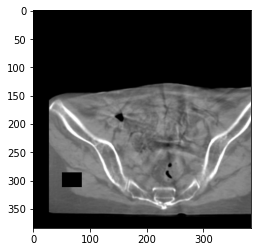

In [31]:
plt.imshow(x.squeeze(), 'gray'),

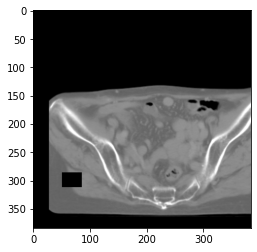

In [32]:
plt.imshow(y.squeeze(), 'gray')

In [33]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [34]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [35]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [36]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [37]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [38]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.

In [39]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [40]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=15, T_mult=5)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=15, T_mult=5)

In [41]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [42]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_d_epoch(epoch, model,                                                                                              
                                                                                                                       tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                                                        edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                                                        trainloader, device)
        loss_mae, loss_air, loss_bone, loss_edge_gen, loss_tf_gen = train_g_epoch(epoch, model, gen_optimizer, 
                                                                                                                                             tf_discriminator, edge_discriminator,
                                                                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

98it [00:30,  3.20it/s]
98it [01:09,  1.40it/s]
98it [00:28,  3.47it/s]
24it [00:07,  3.41it/s]
98it [00:37,  2.58it/s]
98it [01:18,  1.25it/s]
98it [00:28,  3.48it/s]
24it [00:06,  3.44it/s]
98it [00:38,  2.55it/s]
98it [01:08,  1.44it/s]
98it [00:24,  4.07it/s]
24it [00:06,  3.97it/s]
98it [00:31,  3.12it/s]
98it [01:07,  1.45it/s]
98it [00:23,  4.15it/s]
24it [00:05,  4.15it/s]
98it [00:31,  3.11it/s]
98it [01:08,  1.44it/s]
98it [00:24,  4.04it/s]
24it [00:05,  4.28it/s]
98it [00:31,  3.11it/s]
98it [01:04,  1.52it/s]
98it [00:20,  4.74it/s]
24it [00:07,  3.37it/s]
98it [00:38,  2.57it/s]
98it [01:19,  1.24it/s]
98it [00:28,  3.43it/s]
24it [00:07,  3.38it/s]
98it [00:38,  2.57it/s]
98it [01:16,  1.27it/s]
98it [00:24,  4.03it/s]
24it [00:07,  3.41it/s]
98it [00:36,  2.71it/s]
98it [01:12,  1.36it/s]
98it [00:25,  3.83it/s]
24it [00:06,  3.99it/s]
98it [00:34,  2.87it/s]
98it [01:11,  1.36it/s]
98it [00:23,  4.11it/s]
24it [00:05,  4.04it/s]
98it [00:32,  2.99it/s]
98it [01:12,  1.

In [43]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [44]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [45]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.880876362323761
psnr score = 25.588062286376953
snr score = 15.65099811553955
mae error = 0.01822412945330143
air dice score = 0.9921663329014095
bone dice score = 0.9272123225622589
contour dice score = 0.26952892541885376


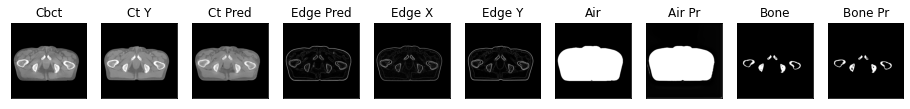

1it [00:00,  2.08it/s]

ssim score = 0.8811166882514954
psnr score = 25.460887908935547
snr score = 15.571357727050781
mae error = 0.01858745701611042
air dice score = 0.992140971929247
bone dice score = 0.9134556574936781
contour dice score = 0.3154121935367584


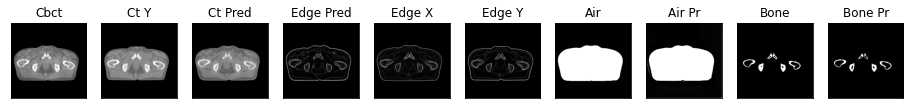

2it [00:00,  2.24it/s]

ssim score = 0.8771092295646667
psnr score = 25.150802612304688
snr score = 15.424174308776855
mae error = 0.02015114761888981
air dice score = 0.9924324960984733
bone dice score = 0.8838250790320887
contour dice score = 0.34548714756965637


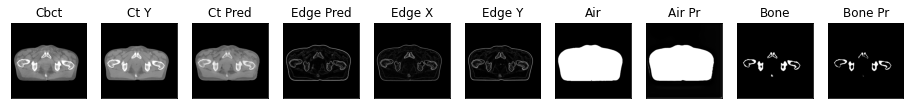

3it [00:01,  2.10it/s]

ssim score = 0.8754749298095703
psnr score = 25.053375244140625
snr score = 15.415997505187988
mae error = 0.020914604887366295
air dice score = 0.9931429358466132
bone dice score = 0.8341571922907296
contour dice score = 0.3666866421699524


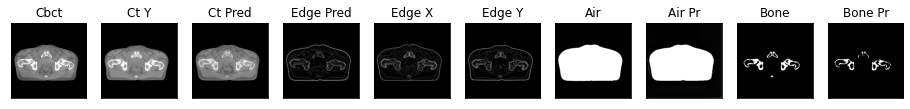

4it [00:01,  2.25it/s]

ssim score = 0.874729573726654
psnr score = 25.136383056640625
snr score = 15.539307594299316
mae error = 0.021133970469236374
air dice score = 0.9937313049744871
bone dice score = 0.8045819014913563
contour dice score = 0.3829531669616699


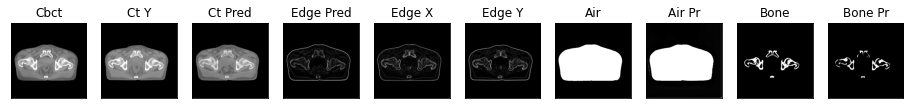

5it [00:02,  2.36it/s]

ssim score = 0.8663972020149231
psnr score = 24.610565185546875
snr score = 15.150023460388184
mae error = 0.023561660200357437
air dice score = 0.9931586983680093
bone dice score = 0.7345888648787219
contour dice score = 0.3614457845687866


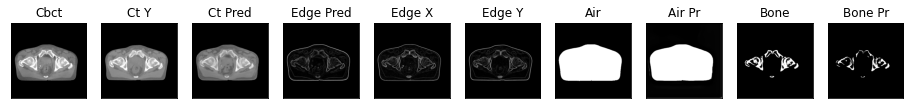

6it [00:02,  2.46it/s]

ssim score = 0.8666300177574158
psnr score = 24.678634643554688
snr score = 15.194038391113281
mae error = 0.022735698148608208
air dice score = 0.991911596038585
bone dice score = 0.7356502904426931
contour dice score = 0.3210621476173401


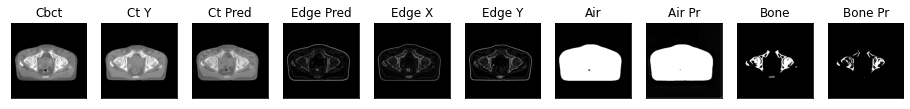

7it [00:02,  2.53it/s]

ssim score = 0.8676525950431824
psnr score = 25.2032470703125
snr score = 15.533112525939941
mae error = 0.020743614062666893
air dice score = 0.9917612467511698
bone dice score = 0.8082135523633653
contour dice score = 0.28831011056900024


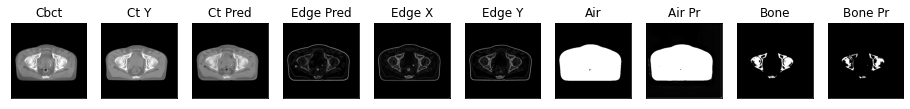

8it [00:03,  2.58it/s]

ssim score = 0.8710403442382812
psnr score = 25.624176025390625
snr score = 15.859484672546387
mae error = 0.019625820219516754
air dice score = 0.9918041060217698
bone dice score = 0.8527282549988899
contour dice score = 0.27582016587257385


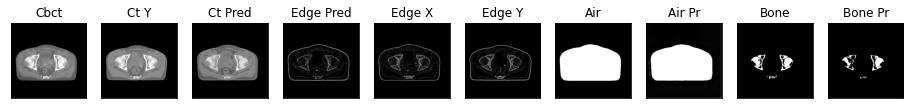

9it [00:03,  2.62it/s]

ssim score = 0.877254843711853
psnr score = 25.770509719848633
snr score = 15.990537643432617
mae error = 0.019313793629407883
air dice score = 0.991049931426839
bone dice score = 0.8471655328815513
contour dice score = 0.2486288845539093


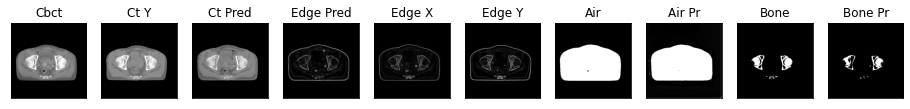

10it [00:03,  2.63it/s]

ssim score = 0.8804742693901062
psnr score = 25.608579635620117
snr score = 15.860876083374023
mae error = 0.01995648629963398
air dice score = 0.9909129893202192
bone dice score = 0.8754264204225922
contour dice score = 0.2608165740966797


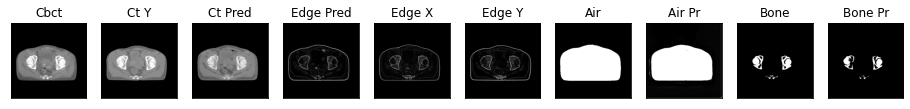

11it [00:04,  2.36it/s]

ssim score = 0.8800800442695618
psnr score = 25.224191665649414
snr score = 15.500200271606445
mae error = 0.0207272469997406
air dice score = 0.9881996787347211
bone dice score = 0.8710554308016657
contour dice score = 0.24190592765808105


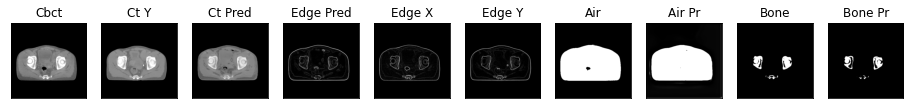

12it [00:04,  2.47it/s]

ssim score = 0.8834595680236816
psnr score = 24.511613845825195
snr score = 14.755699157714844
mae error = 0.02157409116625786
air dice score = 0.9874386490308757
bone dice score = 0.9006556971433792
contour dice score = 0.2529016435146332


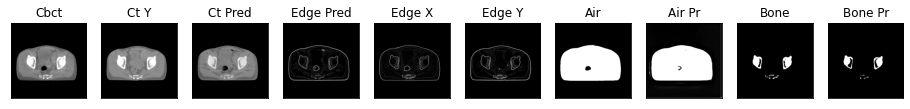

13it [00:05,  2.54it/s]

ssim score = 0.8824306130409241
psnr score = 24.611894607543945
snr score = 14.714022636413574
mae error = 0.020541131496429443
air dice score = 0.9865367489130007
bone dice score = 0.8629834254162572
contour dice score = 0.2339901477098465


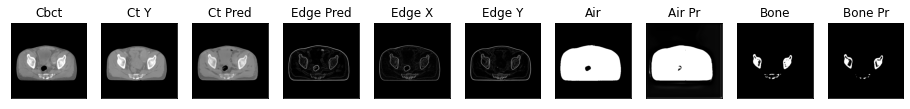

14it [00:05,  2.60it/s]

ssim score = 0.8809410333633423
psnr score = 24.995227813720703
snr score = 15.011693000793457
mae error = 0.019838355481624603
air dice score = 0.9867559429810848
bone dice score = 0.870981692376085
contour dice score = 0.2683076858520508


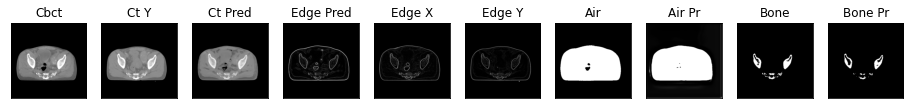

15it [00:05,  2.63it/s]

ssim score = 0.8750391006469727
psnr score = 24.25733184814453
snr score = 14.297281265258789
mae error = 0.02137961983680725
air dice score = 0.9891375835366616
bone dice score = 0.8509615384636459
contour dice score = 0.2746566832065582


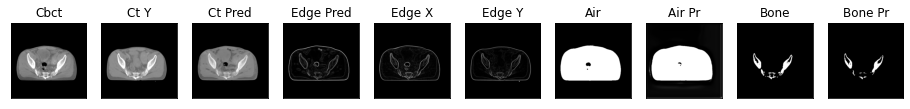

16it [00:06,  2.66it/s]

ssim score = 0.8665774464607239
psnr score = 23.389055252075195
snr score = 13.426464080810547
mae error = 0.023330338299274445
air dice score = 0.9869706840391019
bone dice score = 0.8509955900060003
contour dice score = 0.24466750025749207


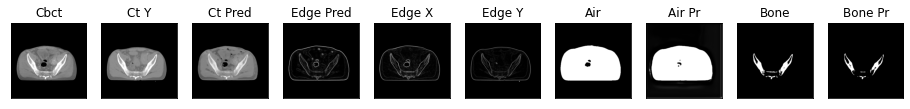

17it [00:06,  2.69it/s]

ssim score = 0.8614715933799744
psnr score = 23.139009475708008
snr score = 13.07465648651123
mae error = 0.023512916639447212
air dice score = 0.9836168327317704
bone dice score = 0.8146819373559447
contour dice score = 0.2227722704410553


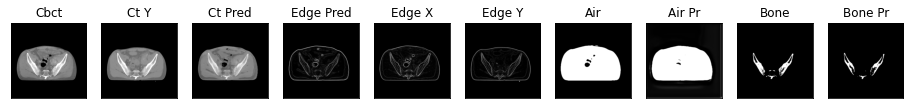

18it [00:07,  2.70it/s]

ssim score = 0.8607860207557678
psnr score = 23.24937629699707
snr score = 13.1343412399292
mae error = 0.023158542811870575
air dice score = 0.9832028826161449
bone dice score = 0.8088779284859724
contour dice score = 0.19387754797935486


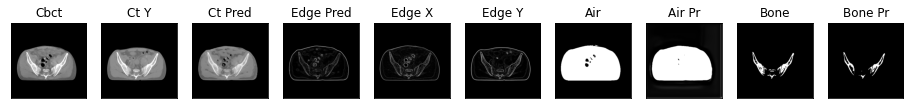

19it [00:07,  2.40it/s]

ssim score = 0.8623459935188293
psnr score = 22.903745651245117
snr score = 12.776402473449707
mae error = 0.024124719202518463
air dice score = 0.9841531134084149
bone dice score = 0.8159663865571993
contour dice score = 0.17330802977085114


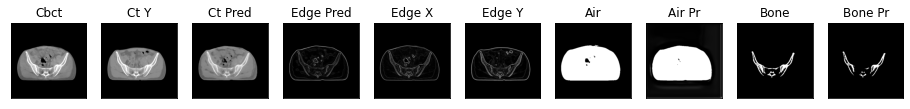

20it [00:07,  2.49it/s]

ssim score = 0.8581976294517517
psnr score = 22.638425827026367
snr score = 12.446233749389648
mae error = 0.02467607893049717
air dice score = 0.9833407177669657
bone dice score = 0.8288019121627009
contour dice score = 0.19552715122699738


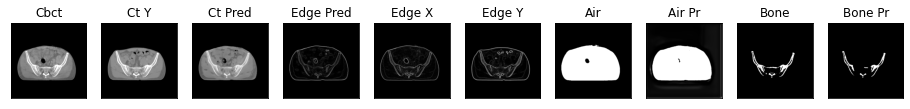

21it [00:08,  2.55it/s]

ssim score = 0.8591477870941162
psnr score = 22.676942825317383
snr score = 12.425322532653809
mae error = 0.02412271499633789
air dice score = 0.9821699544764995
bone dice score = 0.8395419626056017
contour dice score = 0.20258064568042755


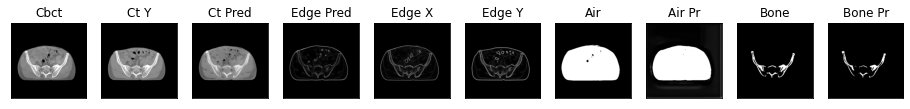

22it [00:08,  2.61it/s]

ssim score = 0.8615915179252625
psnr score = 22.677494049072266
snr score = 12.392443656921387
mae error = 0.024453269317746162
air dice score = 0.9820025291301802
bone dice score = 0.8405315614640015
contour dice score = 0.181700199842453


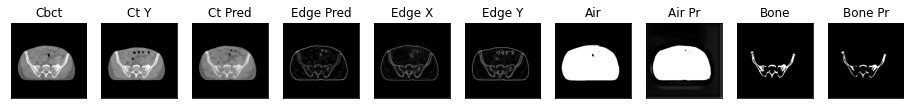

23it [00:09,  2.65it/s]

ssim score = 0.8599570989608765
psnr score = 22.693212509155273
snr score = 12.359599113464355
mae error = 0.024597158655524254
air dice score = 0.9838040056572108
bone dice score = 0.8090747574168501
contour dice score = 0.1944444477558136


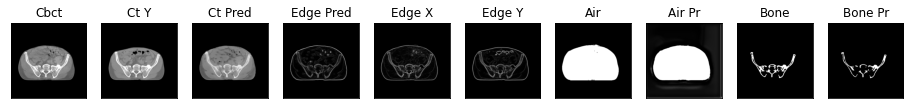

24it [00:09,  2.67it/s]

ssim score = 0.8594355583190918
psnr score = 22.534372329711914
snr score = 12.103758811950684
mae error = 0.02445230446755886
air dice score = 0.97858023482241
bone dice score = 0.8040147913390912
contour dice score = 0.18315507471561432


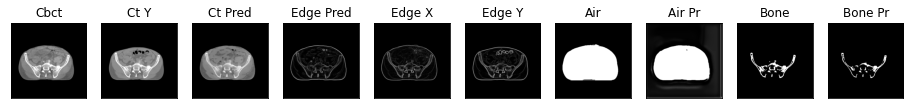

25it [00:09,  2.69it/s]

ssim score = 0.8612322807312012
psnr score = 22.666732788085938
snr score = 12.153386116027832
mae error = 0.024059228599071503
air dice score = 0.9713532246584309
bone dice score = 0.7983182236263524
contour dice score = 0.2337837815284729


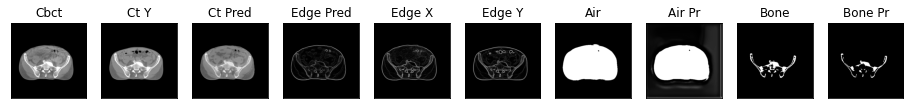

26it [00:10,  2.69it/s]

ssim score = 0.8574984669685364
psnr score = 22.63149642944336
snr score = 12.026963233947754
mae error = 0.02461005002260208
air dice score = 0.9704506045274586
bone dice score = 0.7976699029152405
contour dice score = 0.3199999928474426


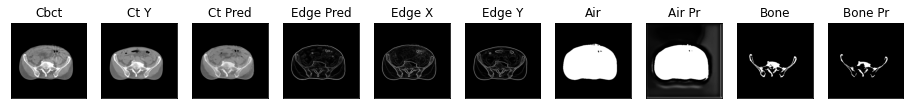

27it [00:10,  2.40it/s]

ssim score = 0.8619069457054138
psnr score = 22.679027557373047
snr score = 12.033387184143066
mae error = 0.02444159798324108
air dice score = 0.9701937406855798
bone dice score = 0.8088324996973424
contour dice score = 0.3251919150352478


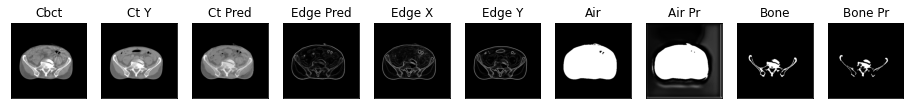

28it [00:11,  2.49it/s]

ssim score = 0.8436164855957031
psnr score = 23.629987716674805
snr score = 15.002143859863281
mae error = 0.024358630180358887
air dice score = 0.994206743375393
bone dice score = 0.9627054361579424
contour dice score = 0.45344826579093933


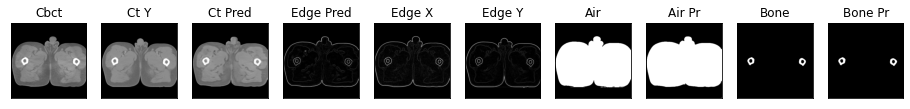

29it [00:11,  2.55it/s]

ssim score = 0.8495136499404907
psnr score = 24.268043518066406
snr score = 15.679458618164062
mae error = 0.023249605670571327
air dice score = 0.9937952746278731
bone dice score = 0.9649227110593067
contour dice score = 0.425839364528656


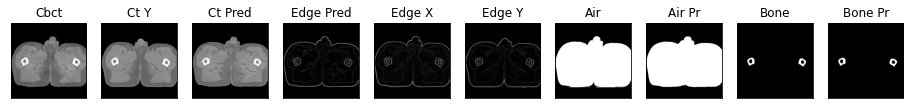

30it [00:11,  2.60it/s]

ssim score = 0.8567954301834106
psnr score = 24.94236183166504
snr score = 16.441225051879883
mae error = 0.022036198526620865
air dice score = 0.9944349939246693
bone dice score = 0.9515587529987636
contour dice score = 0.41655540466308594


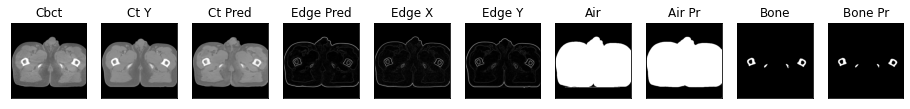

31it [00:12,  2.62it/s]

ssim score = 0.8603547215461731
psnr score = 25.43453025817871
snr score = 17.095951080322266
mae error = 0.021767109632492065
air dice score = 0.9957546514647384
bone dice score = 0.9366280047077387
contour dice score = 0.39246323704719543


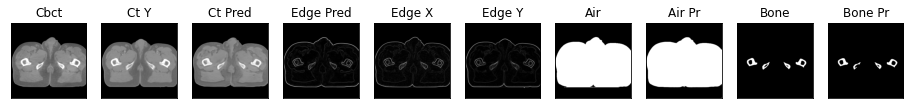

32it [00:12,  2.65it/s]

ssim score = 0.8572567105293274
psnr score = 25.48873519897461
snr score = 17.278295516967773
mae error = 0.02219422347843647
air dice score = 0.9966078452600071
bone dice score = 0.9125925925938875
contour dice score = 0.3625405728816986


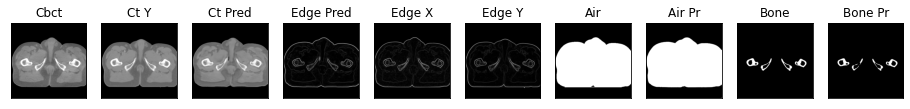

33it [00:12,  2.67it/s]

ssim score = 0.8565090298652649
psnr score = 25.685405731201172
snr score = 17.578208923339844
mae error = 0.02239999547600746
air dice score = 0.9968720413226131
bone dice score = 0.8782493368716413
contour dice score = 0.37105751037597656


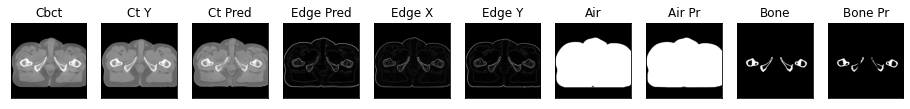

34it [00:13,  2.69it/s]

ssim score = 0.8589712977409363
psnr score = 25.82831573486328
snr score = 17.788217544555664
mae error = 0.022868474945425987
air dice score = 0.9972117571900261
bone dice score = 0.8456325301224192
contour dice score = 0.36700648069381714


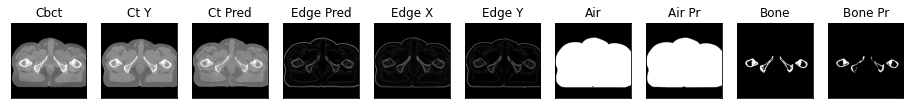

35it [00:13,  2.39it/s]

ssim score = 0.8575077056884766
psnr score = 25.7811279296875
snr score = 17.73114013671875
mae error = 0.022513292729854584
air dice score = 0.997416758925278
bone dice score = 0.8692924363905042
contour dice score = 0.40221914649009705


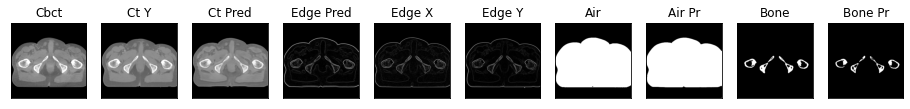

36it [00:14,  2.47it/s]

ssim score = 0.8608161807060242
psnr score = 25.994359970092773
snr score = 17.930709838867188
mae error = 0.02197648584842682
air dice score = 0.9974702486994955
bone dice score = 0.8886616678040369
contour dice score = 0.400740385055542


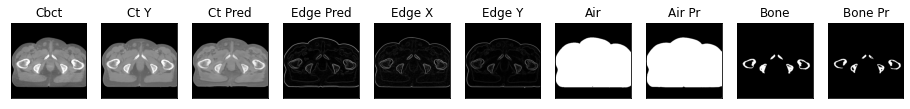

37it [00:14,  2.54it/s]

ssim score = 0.8622804284095764
psnr score = 26.081207275390625
snr score = 18.029556274414062
mae error = 0.021751346066594124
air dice score = 0.9976628584309133
bone dice score = 0.8752427184481159
contour dice score = 0.39944392442703247


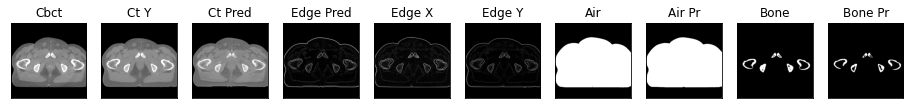

38it [00:14,  2.59it/s]

ssim score = 0.8625656366348267
psnr score = 26.134990692138672
snr score = 18.122426986694336
mae error = 0.02180907502770424
air dice score = 0.9976994865348826
bone dice score = 0.8843873517800841
contour dice score = 0.4130232632160187


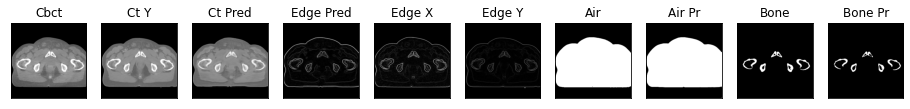

39it [00:15,  2.62it/s]

ssim score = 0.8619228601455688
psnr score = 25.666519165039062
snr score = 17.79524040222168
mae error = 0.023476149886846542
air dice score = 0.9979303187546343
bone dice score = 0.8475536667772958
contour dice score = 0.41658899188041687


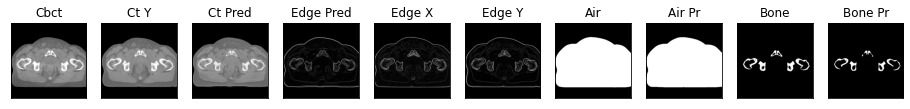

40it [00:15,  2.65it/s]

ssim score = 0.8547295928001404
psnr score = 25.077199935913086
snr score = 17.300609588623047
mae error = 0.026260415092110634
air dice score = 0.9980582063051894
bone dice score = 0.8036418246686349
contour dice score = 0.4586641788482666


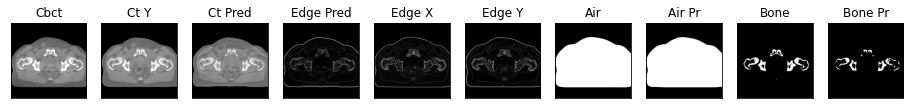

41it [00:16,  2.67it/s]

ssim score = 0.8466162085533142
psnr score = 24.847171783447266
snr score = 17.036535263061523
mae error = 0.02649022452533245
air dice score = 0.99768899054154
bone dice score = 0.7225293376033116
contour dice score = 0.4894712269306183


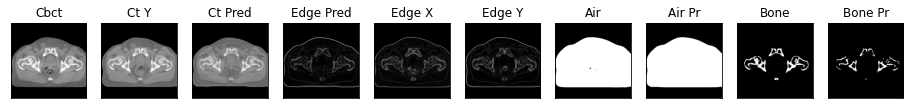

42it [00:16,  2.64it/s]

ssim score = 0.8454180955886841
psnr score = 24.245603561401367
snr score = 16.507152557373047
mae error = 0.02890218049287796
air dice score = 0.996187569201307
bone dice score = 0.6578469520133347
contour dice score = 0.4647887349128723


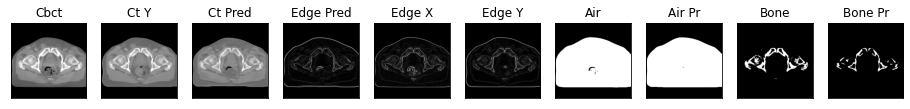

43it [00:16,  2.36it/s]

ssim score = 0.8421332240104675
psnr score = 24.32500648498535
snr score = 16.45046043395996
mae error = 0.027513602748513222
air dice score = 0.996204067413843
bone dice score = 0.7146380697081539
contour dice score = 0.4482109248638153


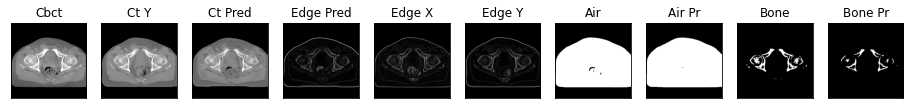

44it [00:17,  2.44it/s]

ssim score = 0.8460665345191956
psnr score = 24.696645736694336
snr score = 16.643539428710938
mae error = 0.024798104539513588
air dice score = 0.9965122372883419
bone dice score = 0.7395673247459561
contour dice score = 0.4588457942008972


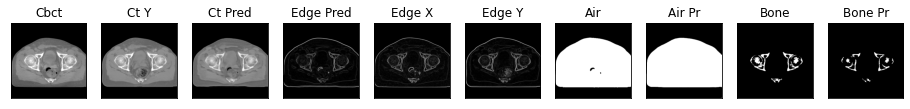

45it [00:17,  2.51it/s]

ssim score = 0.8440884947776794
psnr score = 24.77024269104004
snr score = 16.626548767089844
mae error = 0.02429616078734398
air dice score = 0.9975289845878735
bone dice score = 0.7601679349283631
contour dice score = 0.4662868082523346


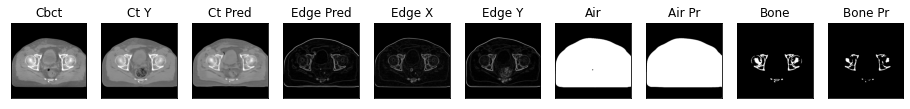

46it [00:18,  2.56it/s]

ssim score = 0.8411669731140137
psnr score = 24.46857452392578
snr score = 16.34056854248047
mae error = 0.02539222128689289
air dice score = 0.9976335525836766
bone dice score = 0.7557411273516427
contour dice score = 0.46241673827171326


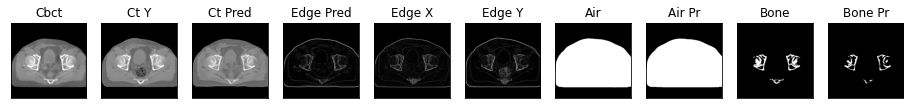

47it [00:18,  2.60it/s]

ssim score = 0.8322124481201172
psnr score = 24.216196060180664
snr score = 16.098228454589844
mae error = 0.026435786858201027
air dice score = 0.9974690029091235
bone dice score = 0.7411751437945057
contour dice score = 0.49833253026008606


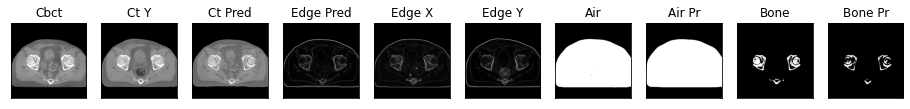

48it [00:18,  2.65it/s]

ssim score = 0.8370620012283325
psnr score = 24.243867874145508
snr score = 16.187488555908203
mae error = 0.02690049819648266
air dice score = 0.9974002141000169
bone dice score = 0.7860854809652551
contour dice score = 0.5121370553970337


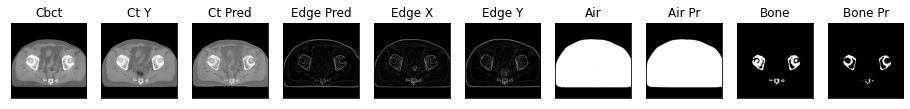

49it [00:19,  2.68it/s]

ssim score = 0.8406539559364319
psnr score = 24.5759220123291
snr score = 16.589624404907227
mae error = 0.027036074548959732
air dice score = 0.9970757545105126
bone dice score = 0.8518810321070329
contour dice score = 0.4762357473373413


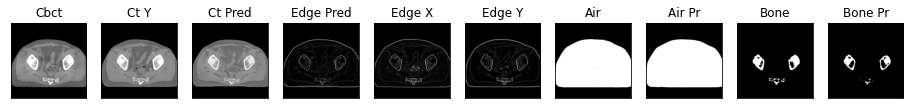

50it [00:19,  2.71it/s]

ssim score = 0.8528311252593994
psnr score = 24.84696388244629
snr score = 16.741561889648438
mae error = 0.02538852021098137
air dice score = 0.9968676633749567
bone dice score = 0.8444006136330878
contour dice score = 0.48098859190940857


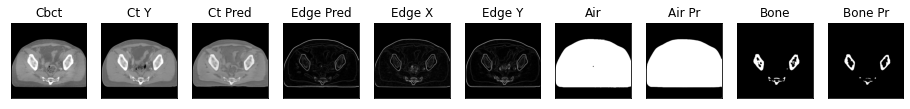

51it [00:20,  2.41it/s]

ssim score = 0.8466349244117737
psnr score = 24.21246337890625
snr score = 16.18868637084961
mae error = 0.027746865525841713
air dice score = 0.9962603208412159
bone dice score = 0.8318379160652982
contour dice score = 0.46536073088645935


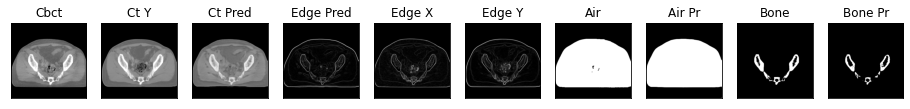

52it [00:20,  2.49it/s]

ssim score = 0.8476999998092651
psnr score = 24.23703956604004
snr score = 16.29340934753418
mae error = 0.02852761372923851
air dice score = 0.9955332080353465
bone dice score = 0.7860738255051504
contour dice score = 0.4753234386444092


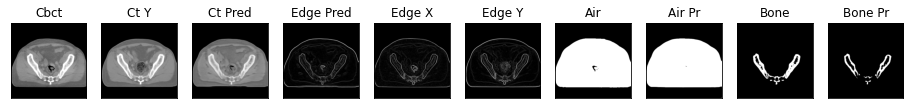

53it [00:20,  2.57it/s]

ssim score = 0.8307516574859619
psnr score = 23.756200790405273
snr score = 15.83413028717041
mae error = 0.030188478529453278
air dice score = 0.9955190804373795
bone dice score = 0.7551337359814052
contour dice score = 0.4511784613132477


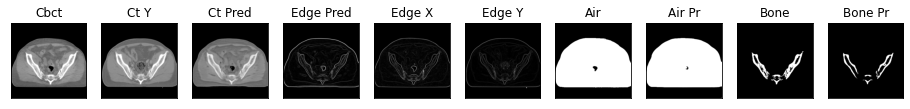

54it [00:21,  2.63it/s]

ssim score = 0.8333742618560791
psnr score = 24.063493728637695
snr score = 16.153961181640625
mae error = 0.029640601947903633
air dice score = 0.9967763201664479
bone dice score = 0.7407472994533315
contour dice score = 0.445297509431839


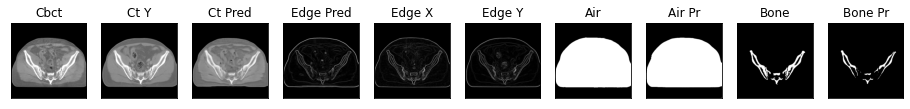

55it [00:21,  2.66it/s]

ssim score = 0.7967521548271179
psnr score = 21.037748336791992
snr score = 10.91795539855957
mae error = 0.031636349856853485
air dice score = 0.9918063380907597
bone dice score = 0.9514354708894168
contour dice score = 0.4262838065624237


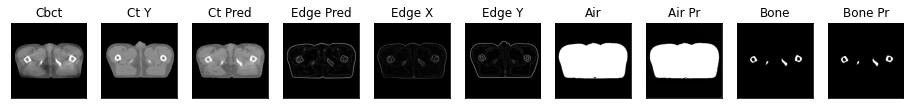

56it [00:21,  2.70it/s]

ssim score = 0.786430835723877
psnr score = 20.776962280273438
snr score = 10.87015151977539
mae error = 0.03348970785737038
air dice score = 0.9927075691013137
bone dice score = 0.923579359897157
contour dice score = 0.41098901629447937


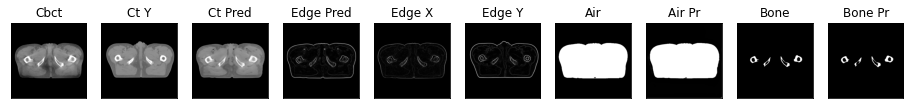

57it [00:22,  2.71it/s]

ssim score = 0.7851001620292664
psnr score = 20.839935302734375
snr score = 11.064261436462402
mae error = 0.03364192321896553
air dice score = 0.9930493234088291
bone dice score = 0.8990750256958052
contour dice score = 0.38402625918388367


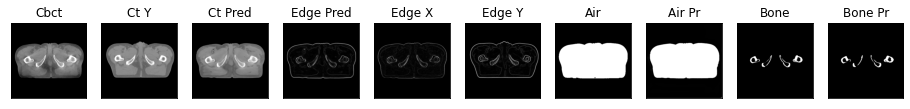

58it [00:22,  2.70it/s]

ssim score = 0.7887825965881348
psnr score = 21.120805740356445
snr score = 11.415534973144531
mae error = 0.03284808248281479
air dice score = 0.992605053797364
bone dice score = 0.8842482100261685
contour dice score = 0.35210496187210083


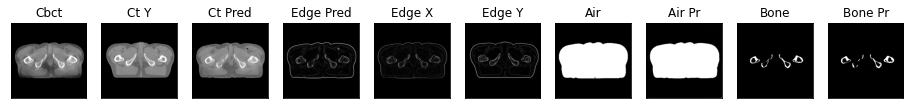

59it [00:23,  2.40it/s]

ssim score = 0.7926979660987854
psnr score = 21.279624938964844
snr score = 11.62192153930664
mae error = 0.03230883181095123
air dice score = 0.9919832329054301
bone dice score = 0.8850283037305284
contour dice score = 0.3567156195640564


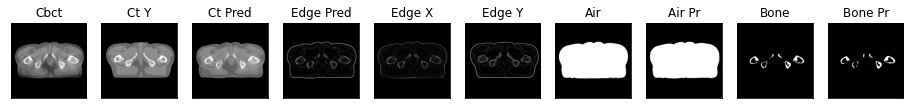

60it [00:23,  2.47it/s]

ssim score = 0.7910835146903992
psnr score = 21.3859920501709
snr score = 11.733904838562012
mae error = 0.03202653303742409
air dice score = 0.9915568476576854
bone dice score = 0.8975869276097741
contour dice score = 0.4091149866580963


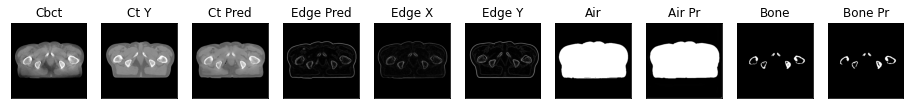

61it [00:23,  2.55it/s]

ssim score = 0.7925184965133667
psnr score = 21.431217193603516
snr score = 11.772624969482422
mae error = 0.032001856714487076
air dice score = 0.9912071315111137
bone dice score = 0.9066366704179483
contour dice score = 0.3955461382865906


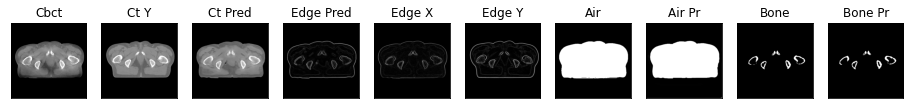

62it [00:24,  2.60it/s]

ssim score = 0.7912861108779907
psnr score = 21.282108306884766
snr score = 11.637626647949219
mae error = 0.032564811408519745
air dice score = 0.9922554406611065
bone dice score = 0.9000923361052614
contour dice score = 0.39406779408454895


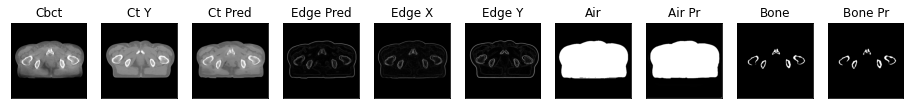

63it [00:24,  2.63it/s]

ssim score = 0.7907720804214478
psnr score = 21.199623107910156
snr score = 11.613149642944336
mae error = 0.03323877230286598
air dice score = 0.9927910796093069
bone dice score = 0.8979863538043271
contour dice score = 0.39595529437065125


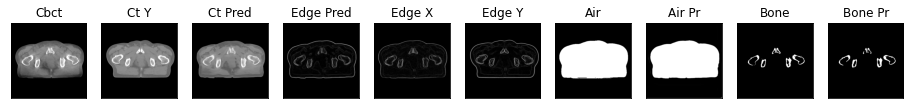

64it [00:24,  2.64it/s]

ssim score = 0.7821047306060791
psnr score = 20.957317352294922
snr score = 11.469403266906738
mae error = 0.03511808067560196
air dice score = 0.99150366221457
bone dice score = 0.8614732724924793
contour dice score = 0.3753943145275116


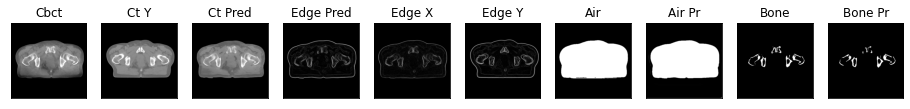

65it [00:25,  2.67it/s]

ssim score = 0.7728960514068604
psnr score = 20.812896728515625
snr score = 11.36081314086914
mae error = 0.036491457372903824
air dice score = 0.9918531327156581
bone dice score = 0.8240273482040692
contour dice score = 0.33780160546302795


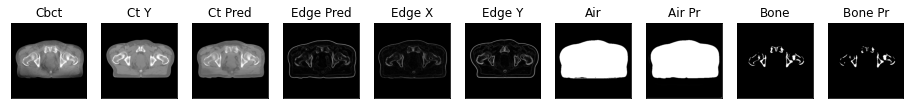

66it [00:25,  2.70it/s]

ssim score = 0.7641971707344055
psnr score = 20.648193359375
snr score = 11.228815078735352
mae error = 0.03718512877821922
air dice score = 0.9917591152434956
bone dice score = 0.7946979966893403
contour dice score = 0.33867520093917847


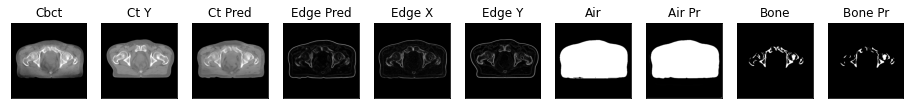

67it [00:26,  2.39it/s]

ssim score = 0.7627196311950684
psnr score = 20.65814781188965
snr score = 11.355587005615234
mae error = 0.036919381469488144
air dice score = 0.9921473615478529
bone dice score = 0.8243064729219975
contour dice score = 0.37368419766426086


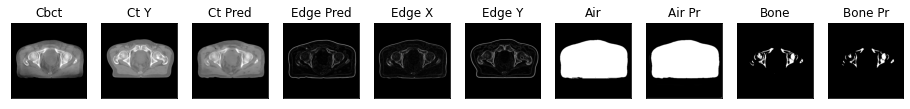

68it [00:26,  2.46it/s]

ssim score = 0.7662688493728638
psnr score = 20.67108154296875
snr score = 11.352533340454102
mae error = 0.03633081540465355
air dice score = 0.9924526681835809
bone dice score = 0.8439412484723999
contour dice score = 0.4028230309486389


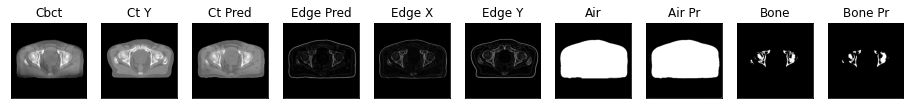

69it [00:26,  2.54it/s]

ssim score = 0.7792161703109741
psnr score = 21.211101531982422
snr score = 11.693390846252441
mae error = 0.033722538501024246
air dice score = 0.9925720069305126
bone dice score = 0.8689567430046286
contour dice score = 0.40639999508857727


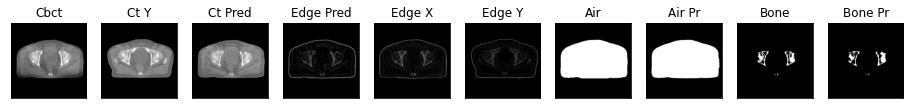

70it [00:27,  2.60it/s]

ssim score = 0.7952893376350403
psnr score = 21.949077606201172
snr score = 12.260974884033203
mae error = 0.03037874959409237
air dice score = 0.9922246960095974
bone dice score = 0.9053835998253574
contour dice score = 0.3746645152568817


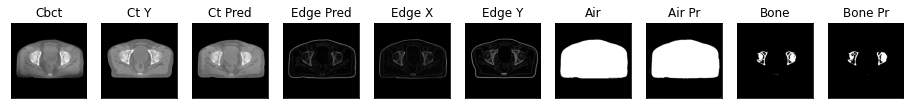

71it [00:27,  2.64it/s]

ssim score = 0.799016535282135
psnr score = 22.337390899658203
snr score = 12.663455963134766
mae error = 0.028949150815606117
air dice score = 0.9923025006193947
bone dice score = 0.9136690647493958
contour dice score = 0.3773987293243408


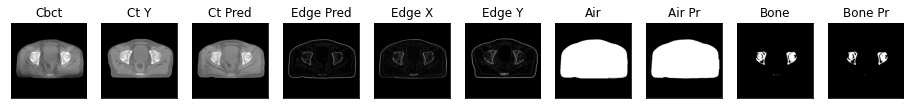

72it [00:28,  2.64it/s]

ssim score = 0.8041349649429321
psnr score = 22.458843231201172
snr score = 12.86673641204834
mae error = 0.02888546697795391
air dice score = 0.9932653617949999
bone dice score = 0.9327542729065179
contour dice score = 0.4353004992008209


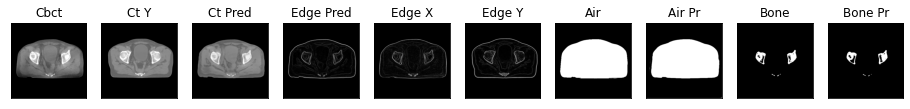

73it [00:28,  2.65it/s]

ssim score = 0.8023459315299988
psnr score = 22.36691665649414
snr score = 12.866982460021973
mae error = 0.029695970937609673
air dice score = 0.9934103682541359
bone dice score = 0.9190608588211452
contour dice score = 0.40944018959999084


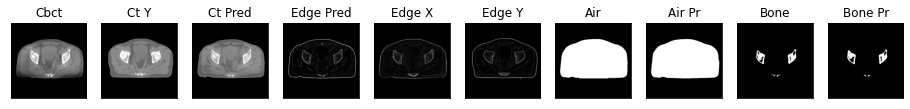

74it [00:28,  2.68it/s]

ssim score = 0.7999918460845947
psnr score = 22.609041213989258
snr score = 13.04568099975586
mae error = 0.028689749538898468
air dice score = 0.9934976304924731
bone dice score = 0.9467021985351982
contour dice score = 0.39914393424987793


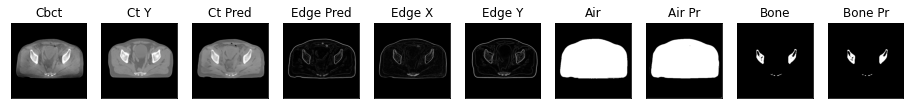

75it [00:29,  2.39it/s]

ssim score = 0.804507851600647
psnr score = 22.81656265258789
snr score = 13.216808319091797
mae error = 0.027851590886712074
air dice score = 0.9929520195174903
bone dice score = 0.9467989179450532
contour dice score = 0.36624205112457275


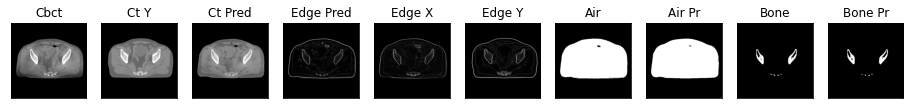

76it [00:29,  2.46it/s]

ssim score = 0.8051186800003052
psnr score = 22.793365478515625
snr score = 13.231353759765625
mae error = 0.02872038260102272
air dice score = 0.9927161853138031
bone dice score = 0.8956627765215874
contour dice score = 0.36228814721107483


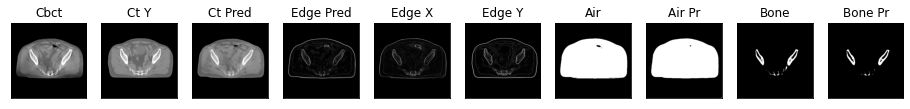

77it [00:30,  2.54it/s]

ssim score = 0.8036258816719055
psnr score = 22.68813133239746
snr score = 13.256624221801758
mae error = 0.029581421986222267
air dice score = 0.9924703647803073
bone dice score = 0.8935849056619837
contour dice score = 0.36373332142829895


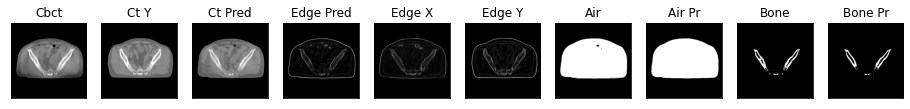

78it [00:30,  2.58it/s]

ssim score = 0.8064326047897339
psnr score = 22.58970069885254
snr score = 13.175945281982422
mae error = 0.03009040467441082
air dice score = 0.9927028430813307
bone dice score = 0.8663564896539971
contour dice score = 0.3626609444618225


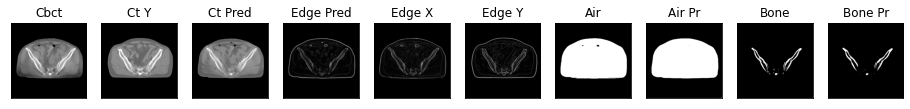

79it [00:30,  2.62it/s]

ssim score = 0.810605525970459
psnr score = 22.933443069458008
snr score = 13.508417129516602
mae error = 0.029194530099630356
air dice score = 0.9931539672759694
bone dice score = 0.8685121107289184
contour dice score = 0.33872708678245544


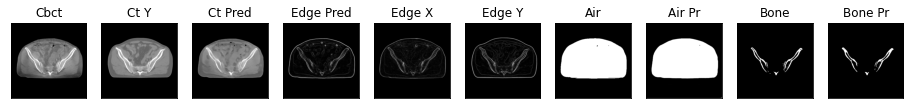

80it [00:31,  2.63it/s]

ssim score = 0.8096032738685608
psnr score = 22.95250701904297
snr score = 13.526742935180664
mae error = 0.028882397338747978
air dice score = 0.9933045115043849
bone dice score = 0.8515691263808046
contour dice score = 0.32191407680511475


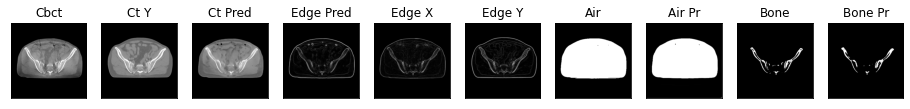

81it [00:31,  2.67it/s]

ssim score = 0.8511204719543457
psnr score = 23.893798828125
snr score = 14.327935218811035
mae error = 0.021213332191109657
air dice score = 0.990619701795257
bone dice score = 0.9061282323802292
contour dice score = 0.26588982343673706


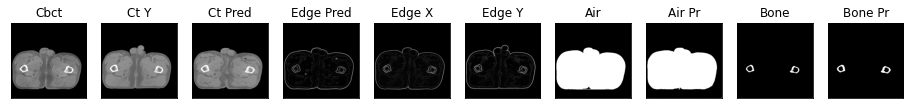

82it [00:31,  2.69it/s]

ssim score = 0.8528633117675781
psnr score = 24.237892150878906
snr score = 14.736418724060059
mae error = 0.020774848759174347
air dice score = 0.9908375314861533
bone dice score = 0.8929604628771147
contour dice score = 0.2720588147640228


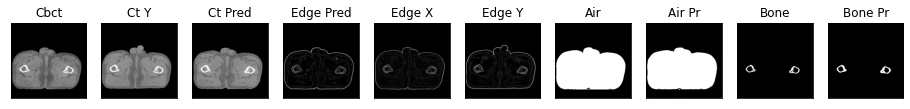

83it [00:32,  2.38it/s]

ssim score = 0.8612484335899353
psnr score = 25.65427017211914
snr score = 16.292009353637695
mae error = 0.019798168912529945
air dice score = 0.9912580471894261
bone dice score = 0.9299585424409784
contour dice score = 0.30707070231437683


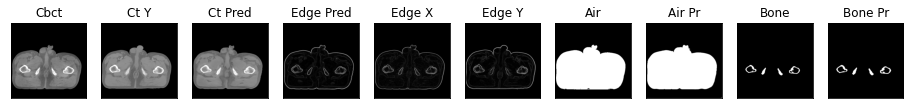

84it [00:32,  2.45it/s]

ssim score = 0.8592978119850159
psnr score = 25.53999900817871
snr score = 16.299230575561523
mae error = 0.0203557051718235
air dice score = 0.9922879575876481
bone dice score = 0.9078698845769597
contour dice score = 0.3247687518596649


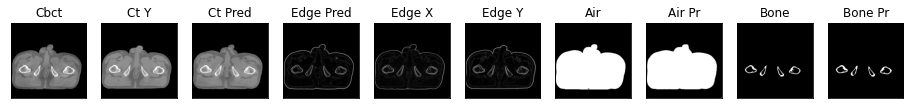

85it [00:33,  2.52it/s]

ssim score = 0.8555020093917847
psnr score = 25.374462127685547
snr score = 16.157867431640625
mae error = 0.020561426877975464
air dice score = 0.9925822794601132
bone dice score = 0.8896291361339189
contour dice score = 0.3385254442691803


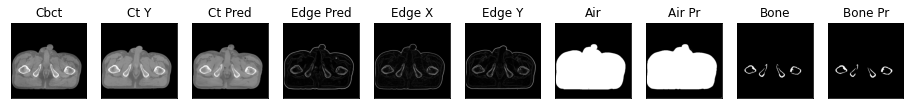

86it [00:33,  2.59it/s]

ssim score = 0.8568281531333923
psnr score = 25.315025329589844
snr score = 16.09403419494629
mae error = 0.02073788456618786
air dice score = 0.9933684747491974
bone dice score = 0.8766783722396885
contour dice score = 0.3383970558643341


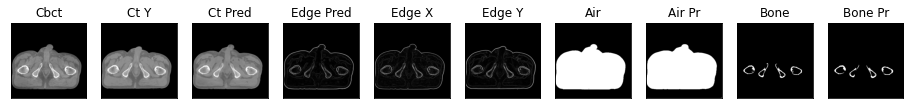

87it [00:33,  2.63it/s]

ssim score = 0.8590630888938904
psnr score = 24.914724349975586
snr score = 15.699987411499023
mae error = 0.021267682313919067
air dice score = 0.9936241740407329
bone dice score = 0.8813423891354106
contour dice score = 0.32842105627059937


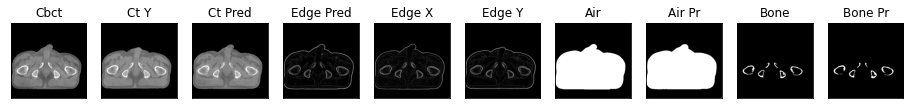

88it [00:34,  2.65it/s]

ssim score = 0.8546939492225647
psnr score = 24.73069953918457
snr score = 15.494403839111328
mae error = 0.021557103842496872
air dice score = 0.9943215225127694
bone dice score = 0.8893241919708261
contour dice score = 0.4061020612716675


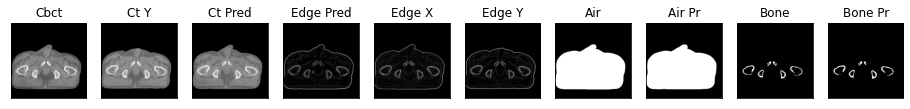

89it [00:34,  2.67it/s]

ssim score = 0.8554376363754272
psnr score = 24.774391174316406
snr score = 15.555008888244629
mae error = 0.021662350744009018
air dice score = 0.9948553204367198
bone dice score = 0.9032378116876956
contour dice score = 0.4076230823993683


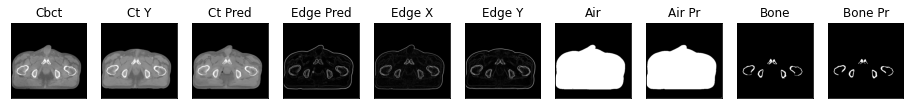

90it [00:35,  2.70it/s]

ssim score = 0.8554009199142456
psnr score = 24.985279083251953
snr score = 15.834491729736328
mae error = 0.021686626598238945
air dice score = 0.9950452626166661
bone dice score = 0.8938873626391847
contour dice score = 0.42940863966941833


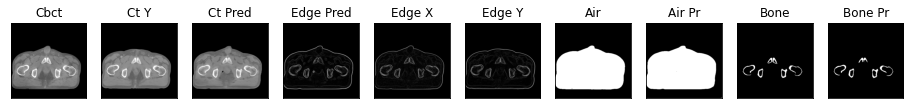

91it [00:35,  2.40it/s]

ssim score = 0.857422411441803
psnr score = 25.268310546875
snr score = 16.19887924194336
mae error = 0.021622227504849434
air dice score = 0.9951275975067102
bone dice score = 0.8710093518240727
contour dice score = 0.44849786162376404


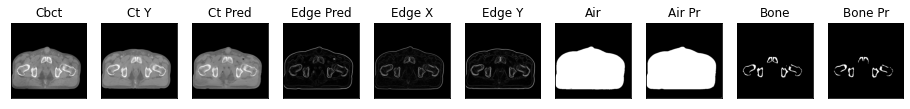

92it [00:35,  2.49it/s]

ssim score = 0.861217737197876
psnr score = 25.64998435974121
snr score = 16.631256103515625
mae error = 0.021405650302767754
air dice score = 0.9958057117722864
bone dice score = 0.8178694158105405
contour dice score = 0.45732688903808594


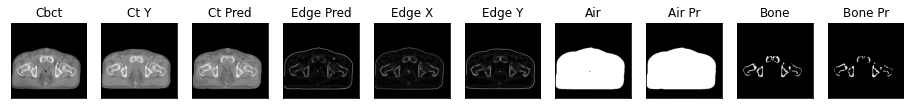

93it [00:36,  2.55it/s]

ssim score = 0.8625332117080688
psnr score = 25.742921829223633
snr score = 16.8404598236084
mae error = 0.022223467007279396
air dice score = 0.9958542198682211
bone dice score = 0.7820773930787706
contour dice score = 0.43133047223091125


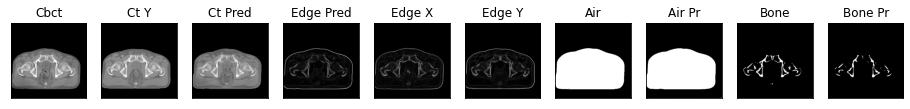

94it [00:36,  2.60it/s]

ssim score = 0.8597478270530701
psnr score = 25.94608497619629
snr score = 17.005390167236328
mae error = 0.021497422829270363
air dice score = 0.9944617624254359
bone dice score = 0.7999340804251823
contour dice score = 0.36627283692359924


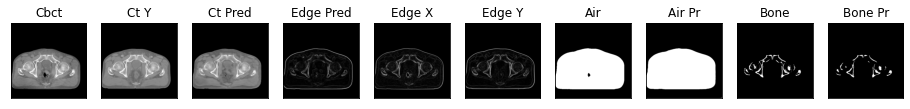

95it [00:37,  2.64it/s]

ssim score = 0.8557548522949219
psnr score = 25.25191307067871
snr score = 16.215545654296875
mae error = 0.021713608875870705
air dice score = 0.9932242525578302
bone dice score = 0.7830073349666411
contour dice score = 0.38598382472991943


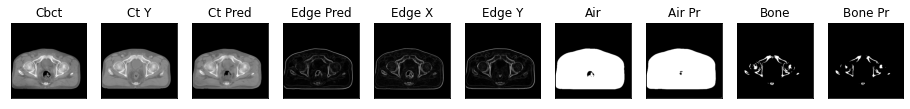

96it [00:37,  2.66it/s]

ssim score = 0.8603126406669617
psnr score = 25.09960174560547
snr score = 15.903477668762207
mae error = 0.0207029078155756
air dice score = 0.9930651872399501
bone dice score = 0.8535388927846261
contour dice score = 0.3952483832836151


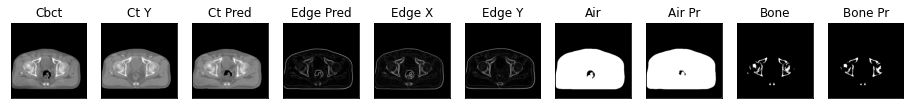

97it [00:37,  2.69it/s]

ssim score = 0.8615522384643555
psnr score = 24.599855422973633
snr score = 15.287304878234863
mae error = 0.020810315385460854
air dice score = 0.9928915906788305
bone dice score = 0.8563419761763079
contour dice score = 0.34127843379974365


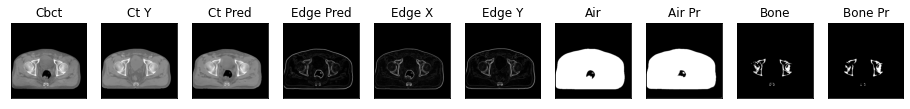

98it [00:38,  2.70it/s]

ssim score = 0.8568904995918274
psnr score = 24.509567260742188
snr score = 15.151922225952148
mae error = 0.02118825912475586
air dice score = 0.9923186065854557
bone dice score = 0.8738857708835608
contour dice score = 0.33170202374458313


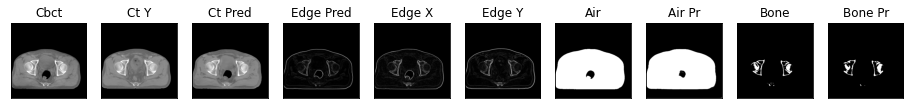

99it [00:38,  2.39it/s]

ssim score = 0.8517586588859558
psnr score = 23.920543670654297
snr score = 14.569572448730469
mae error = 0.022734982892870903
air dice score = 0.99244373647021
bone dice score = 0.8894789246616416
contour dice score = 0.3540304899215698


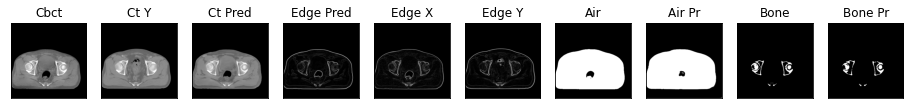

100it [00:39,  2.48it/s]

ssim score = 0.8513069152832031
psnr score = 23.645854949951172
snr score = 14.324987411499023
mae error = 0.023560835048556328
air dice score = 0.9919204474829152
bone dice score = 0.9167855444616138
contour dice score = 0.3790278434753418


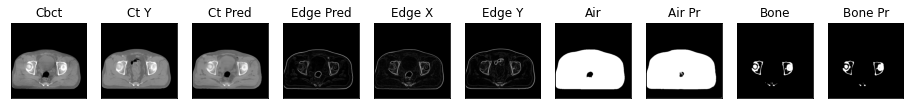

101it [00:39,  2.54it/s]

ssim score = 0.859694242477417
psnr score = 24.677539825439453
snr score = 15.3140869140625
mae error = 0.021563688293099403
air dice score = 0.992288715711748
bone dice score = 0.9143454039012127
contour dice score = 0.4032786786556244


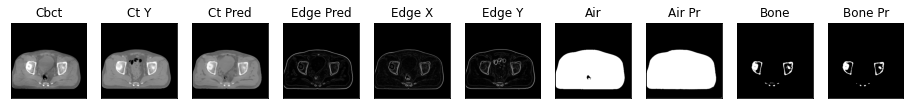

102it [00:39,  2.60it/s]

ssim score = 0.8626524806022644
psnr score = 24.55490493774414
snr score = 15.101247787475586
mae error = 0.020957108587026596
air dice score = 0.9930854168893477
bone dice score = 0.9054396568550314
contour dice score = 0.381212443113327


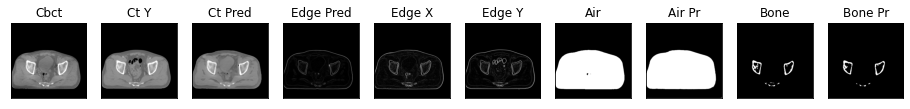

103it [00:40,  2.63it/s]

ssim score = 0.8645126819610596
psnr score = 24.350399017333984
snr score = 14.83101749420166
mae error = 0.021424254402518272
air dice score = 0.991821363990783
bone dice score = 0.9286846275766901
contour dice score = 0.39320918917655945


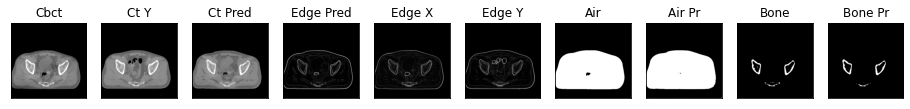

104it [00:40,  2.64it/s]

ssim score = 0.8643574118614197
psnr score = 24.64933204650879
snr score = 15.129646301269531
mae error = 0.021030964329838753
air dice score = 0.9918355408849774
bone dice score = 0.9159078735955024
contour dice score = 0.3769230842590332


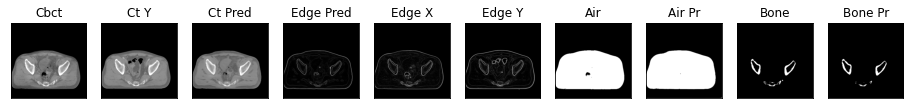

105it [00:40,  2.67it/s]

ssim score = 0.8596060276031494
psnr score = 24.569293975830078
snr score = 15.125774383544922
mae error = 0.022271856665611267
air dice score = 0.9912141652613902
bone dice score = 0.8623400647469964
contour dice score = 0.43463870882987976


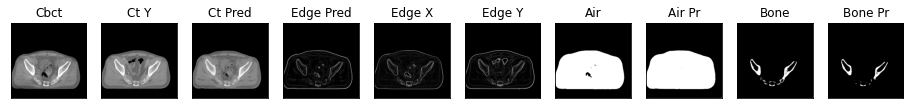

106it [00:41,  2.68it/s]

ssim score = 0.863402247428894
psnr score = 24.718162536621094
snr score = 15.310225486755371
mae error = 0.02225179597735405
air dice score = 0.9916893744535347
bone dice score = 0.8412419449349554
contour dice score = 0.41698840260505676


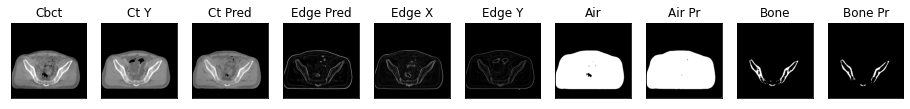

107it [00:41,  2.38it/s]

ssim score = 0.8652823567390442
psnr score = 25.06818389892578
snr score = 15.598546981811523
mae error = 0.021150602027773857
air dice score = 0.9928029266958486
bone dice score = 0.8567547169832943
contour dice score = 0.3734072148799896


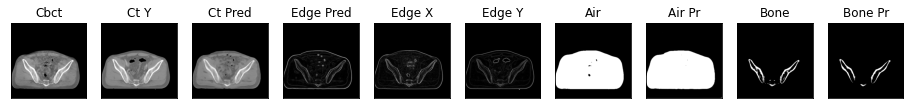

108it [00:42,  2.46it/s]

ssim score = 0.8609314560890198
psnr score = 24.955524444580078
snr score = 15.424628257751465
mae error = 0.02113255113363266
air dice score = 0.9931534017418356
bone dice score = 0.8461416574259841
contour dice score = 0.35426008701324463


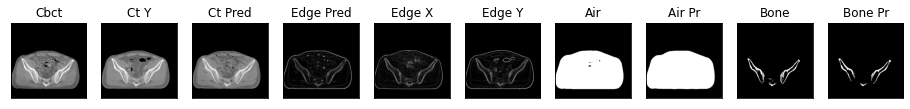

109it [00:42,  2.51it/s]

ssim score = 0.7809872031211853
psnr score = 22.477035522460938
snr score = 14.174342155456543
mae error = 0.03131935000419617
air dice score = 0.9953422390353497
bone dice score = 0.9554300062788629
contour dice score = 0.4245908856391907


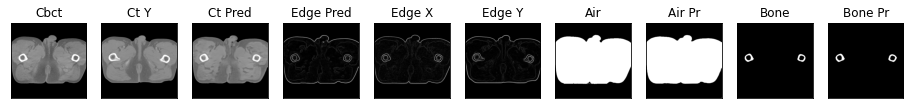

110it [00:42,  2.55it/s]

ssim score = 0.7729962468147278
psnr score = 22.22709846496582
snr score = 14.028696060180664
mae error = 0.03217748552560806
air dice score = 0.9958787251679988
bone dice score = 0.9522733691061205
contour dice score = 0.43772241473197937


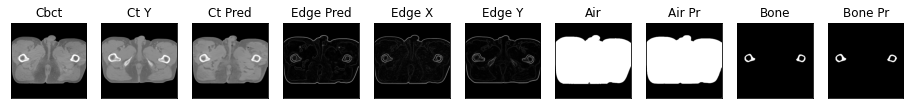

111it [00:43,  2.60it/s]

ssim score = 0.7695863842964172
psnr score = 22.01124382019043
snr score = 13.940796852111816
mae error = 0.03353579714894295
air dice score = 0.9961315733946052
bone dice score = 0.9163957268946494
contour dice score = 0.4225604236125946


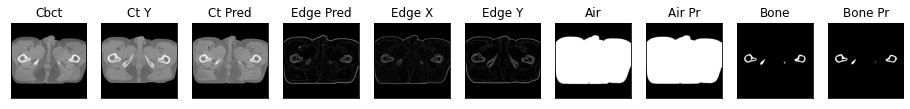

112it [00:43,  2.65it/s]

ssim score = 0.7671813368797302
psnr score = 21.77192497253418
snr score = 13.73376750946045
mae error = 0.034614529460668564
air dice score = 0.9960175671487325
bone dice score = 0.8995786516871562
contour dice score = 0.4211944341659546


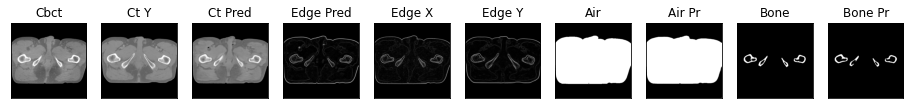

113it [00:43,  2.68it/s]

ssim score = 0.7606585621833801
psnr score = 21.767786026000977
snr score = 13.759866714477539
mae error = 0.03508403152227402
air dice score = 0.9963655031998762
bone dice score = 0.8434032059213774
contour dice score = 0.4492557644844055


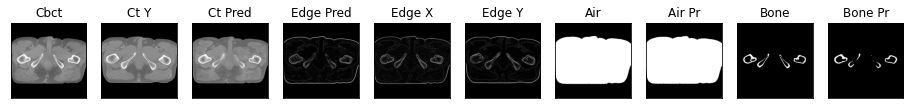

114it [00:44,  2.70it/s]

ssim score = 0.7564283609390259
psnr score = 21.68216323852539
snr score = 13.708660125732422
mae error = 0.03572878614068031
air dice score = 0.9963009922181273
bone dice score = 0.8534903280091928
contour dice score = 0.46008118987083435


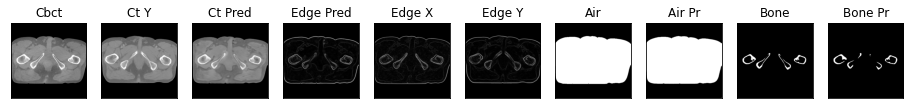

115it [00:44,  2.41it/s]

ssim score = 0.7446597218513489
psnr score = 21.2838134765625
snr score = 13.330619812011719
mae error = 0.03767281770706177
air dice score = 0.9964373229523317
bone dice score = 0.8216463414661335
contour dice score = 0.4579397141933441


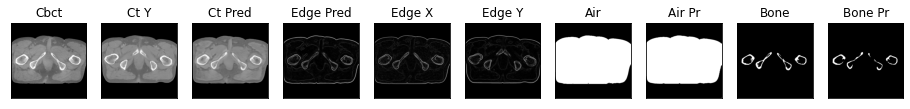

116it [00:45,  2.50it/s]

ssim score = 0.740530252456665
psnr score = 21.156723022460938
snr score = 13.242606163024902
mae error = 0.038011349737644196
air dice score = 0.9959563821479213
bone dice score = 0.8424996253582722
contour dice score = 0.5087170600891113


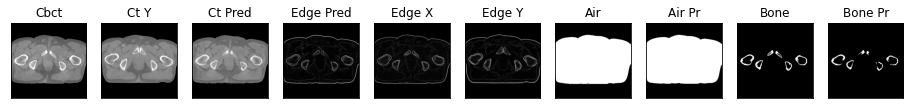

117it [00:45,  2.57it/s]

ssim score = 0.7395477890968323
psnr score = 21.174772262573242
snr score = 13.309334754943848
mae error = 0.0385543517768383
air dice score = 0.995452862498267
bone dice score = 0.8466772839170887
contour dice score = 0.5097529292106628


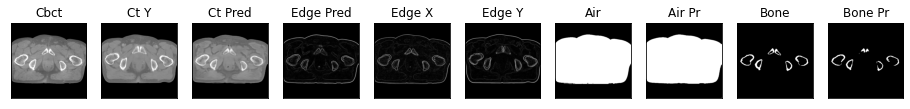

118it [00:45,  2.63it/s]

ssim score = 0.7296621203422546
psnr score = 20.931610107421875
snr score = 13.088784217834473
mae error = 0.040642544627189636
air dice score = 0.995587172146557
bone dice score = 0.8334036271638774
contour dice score = 0.5167586207389832


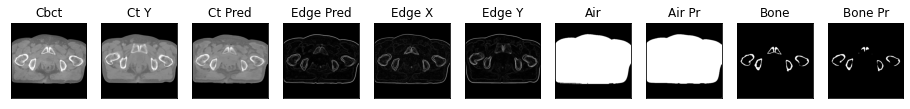

119it [00:46,  2.66it/s]

ssim score = 0.7222575545310974
psnr score = 20.89143943786621
snr score = 13.091391563415527
mae error = 0.041715193539857864
air dice score = 0.9961047729515456
bone dice score = 0.8070834451327196
contour dice score = 0.5318606495857239


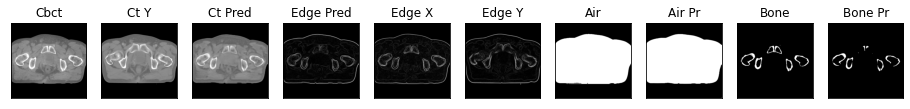

120it [00:46,  2.67it/s]

ssim score = 0.7305243015289307
psnr score = 21.11739158630371
snr score = 13.375680923461914
mae error = 0.04079949110746384
air dice score = 0.9961696841427246
bone dice score = 0.8007458048502083
contour dice score = 0.47351741790771484


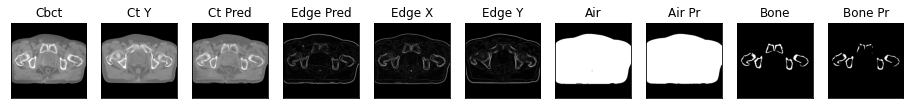

121it [00:47,  2.66it/s]

ssim score = 0.7248666882514954
psnr score = 21.03738021850586
snr score = 13.220296859741211
mae error = 0.04250713437795639
air dice score = 0.9966900736688483
bone dice score = 0.7459867799841124
contour dice score = 0.48338642716407776


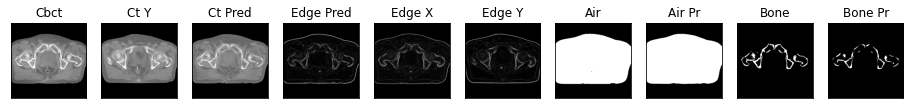

122it [00:47,  2.67it/s]

ssim score = 0.7250281572341919
psnr score = 20.955223083496094
snr score = 13.030921936035156
mae error = 0.043595585972070694
air dice score = 0.996811938858159
bone dice score = 0.7355169600217331
contour dice score = 0.47423622012138367


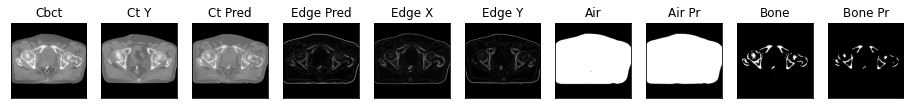

123it [00:47,  2.38it/s]

ssim score = 0.7317976951599121
psnr score = 21.072805404663086
snr score = 13.025416374206543
mae error = 0.04229505732655525
air dice score = 0.9965891116160038
bone dice score = 0.6779376498839575
contour dice score = 0.44780218601226807


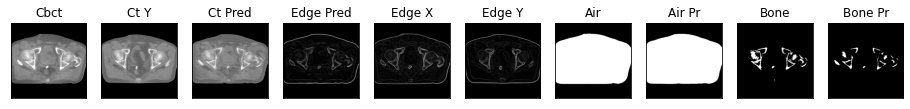

124it [00:48,  2.47it/s]

ssim score = 0.7355782985687256
psnr score = 21.256031036376953
snr score = 13.096212387084961
mae error = 0.04069196432828903
air dice score = 0.9968989924607493
bone dice score = 0.7584960231410158
contour dice score = 0.44894203543663025


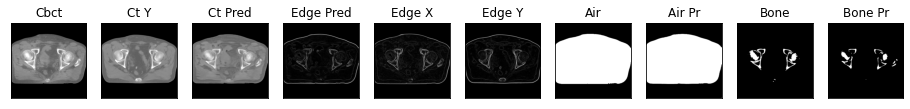

125it [00:48,  2.52it/s]

ssim score = 0.7317400574684143
psnr score = 21.491249084472656
snr score = 13.280782699584961
mae error = 0.03844764456152916
air dice score = 0.9968853832596591
bone dice score = 0.813197135143675
contour dice score = 0.43253234028816223


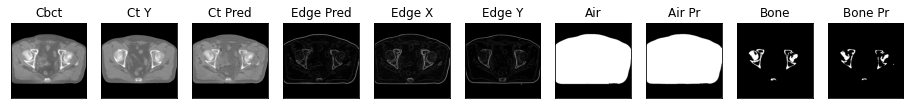

126it [00:49,  2.56it/s]

ssim score = 0.7339377999305725
psnr score = 21.324365615844727
snr score = 13.146056175231934
mae error = 0.03880438208580017
air dice score = 0.9971130434782626
bone dice score = 0.8227989569126686
contour dice score = 0.4230055510997772


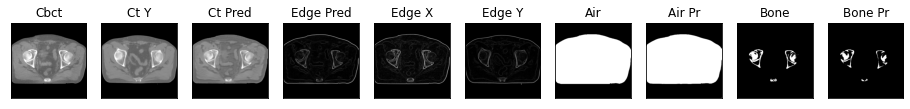

127it [00:49,  2.57it/s]

ssim score = 0.7337563633918762
psnr score = 21.06304931640625
snr score = 12.898215293884277
mae error = 0.03980295732617378
air dice score = 0.9970152727272744
bone dice score = 0.8350159404910332
contour dice score = 0.42630597949028015


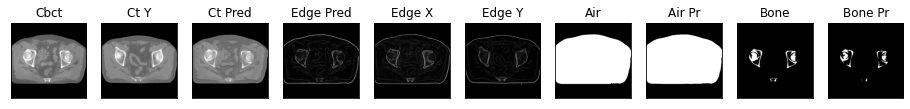

128it [00:49,  2.61it/s]

ssim score = 0.7365769147872925
psnr score = 20.769268035888672
snr score = 12.462944030761719
mae error = 0.04127832129597664
air dice score = 0.9970183808053897
bone dice score = 0.846355532251621
contour dice score = 0.43588539958000183


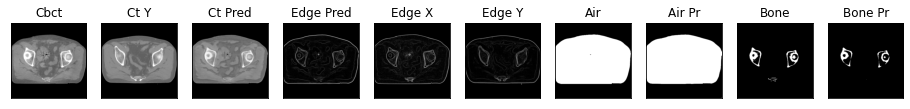

129it [00:50,  2.64it/s]

ssim score = 0.7465997338294983
psnr score = 20.854265213012695
snr score = 12.488632202148438
mae error = 0.0404093936085701
air dice score = 0.997013942771157
bone dice score = 0.8733402953920134
contour dice score = 0.4376181364059448


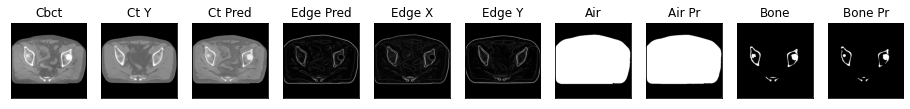

130it [00:50,  2.65it/s]

ssim score = 0.7418698072433472
psnr score = 21.08738136291504
snr score = 12.747393608093262
mae error = 0.038751520216464996
air dice score = 0.9968342842293036
bone dice score = 0.8801280768485066
contour dice score = 0.4380321800708771


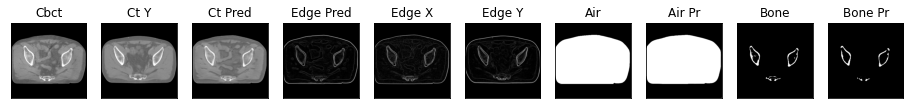

131it [00:51,  2.37it/s]

ssim score = 0.7404960989952087
psnr score = 21.173391342163086
snr score = 12.906218528747559
mae error = 0.038288384675979614
air dice score = 0.9965340834906072
bone dice score = 0.8839368616548944
contour dice score = 0.47871333360671997


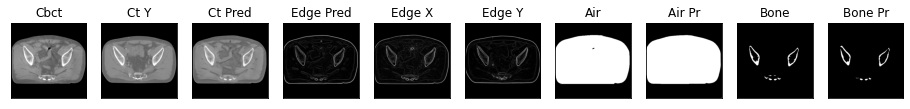

132it [00:51,  2.46it/s]

ssim score = 0.7335414290428162
psnr score = 20.887283325195312
snr score = 12.74934196472168
mae error = 0.0402187742292881
air dice score = 0.9961807917696085
bone dice score = 0.875566399444483
contour dice score = 0.49642688035964966


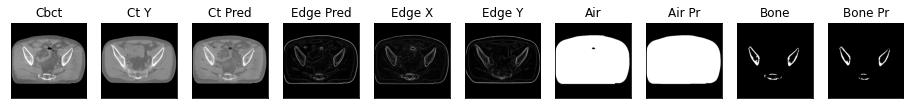

133it [00:51,  2.53it/s]

ssim score = 0.7314479351043701
psnr score = 20.662229537963867
snr score = 12.558245658874512
mae error = 0.04094826802611351
air dice score = 0.9959086709779621
bone dice score = 0.8624475298698345
contour dice score = 0.5086206793785095


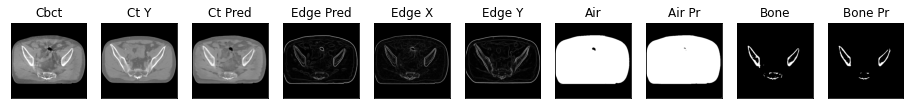

134it [00:52,  2.58it/s]

ssim score = 0.7226436734199524
psnr score = 20.737836837768555
snr score = 12.604063987731934
mae error = 0.04127538949251175
air dice score = 0.9964901718792352
bone dice score = 0.8006109414079338
contour dice score = 0.48918789625167847


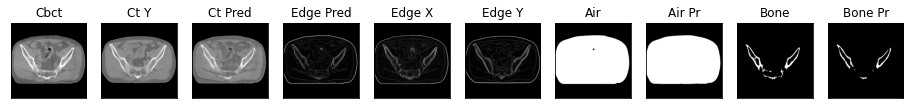

135it [00:52,  2.60it/s]

ssim score = 0.7217473387718201
psnr score = 20.954002380371094
snr score = 12.756855010986328
mae error = 0.0398704931139946
air dice score = 0.9967852265448456
bone dice score = 0.7923169267738248
contour dice score = 0.5159112811088562


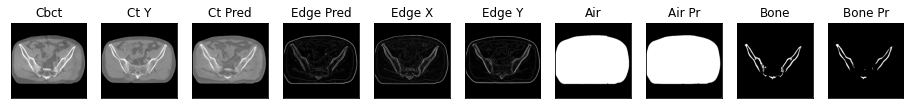

136it [00:52,  2.63it/s]

ssim score = 0.8208289742469788
psnr score = 23.07346534729004
snr score = 14.550858497619629
mae error = 0.029274195432662964
air dice score = 0.9957061209985522
bone dice score = 0.819632560013147
contour dice score = 0.4777165651321411


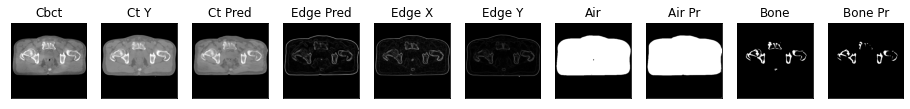

137it [00:53,  2.64it/s]

ssim score = 0.8236458897590637
psnr score = 23.216447830200195
snr score = 14.733850479125977
mae error = 0.028935560956597328
air dice score = 0.9956966909036981
bone dice score = 0.8050632911419823
contour dice score = 0.43360161781311035


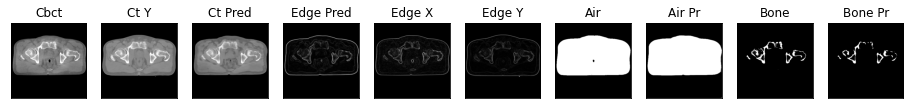

138it [00:53,  2.65it/s]

ssim score = 0.8221284747123718
psnr score = 23.287622451782227
snr score = 14.812811851501465
mae error = 0.028806796297430992
air dice score = 0.9963462995143278
bone dice score = 0.7861635220157808
contour dice score = 0.4567963480949402


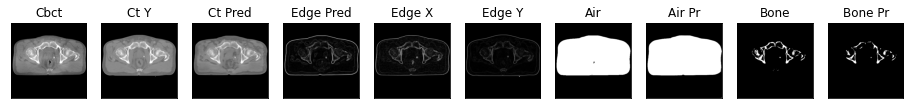

139it [00:54,  2.37it/s]

ssim score = 0.8259298205375671
psnr score = 23.447555541992188
snr score = 14.914327621459961
mae error = 0.027596797794103622
air dice score = 0.9954736983160405
bone dice score = 0.7826086956552427
contour dice score = 0.4974670708179474


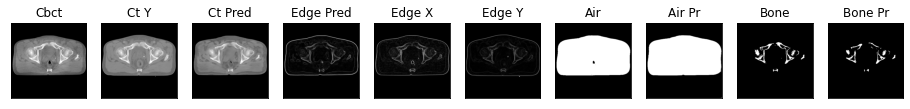

140it [00:54,  2.44it/s]

ssim score = 0.8331235647201538
psnr score = 23.661579132080078
snr score = 14.972723960876465
mae error = 0.025354167446494102
air dice score = 0.9952148109439773
bone dice score = 0.8330937549938813
contour dice score = 0.5178026556968689


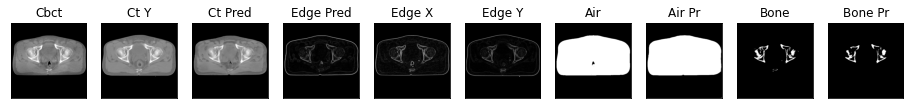

141it [00:54,  2.51it/s]

ssim score = 0.8320373892784119
psnr score = 23.748302459716797
snr score = 15.038644790649414
mae error = 0.024839524179697037
air dice score = 0.995649992887255
bone dice score = 0.8499849985021004
contour dice score = 0.4946455955505371


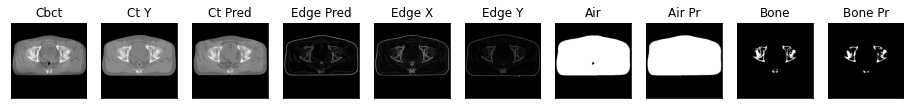

142it [00:55,  2.56it/s]

ssim score = 0.8305002450942993
psnr score = 23.579097747802734
snr score = 14.853809356689453
mae error = 0.025457557290792465
air dice score = 0.9955756533235215
bone dice score = 0.8521457965924141
contour dice score = 0.4634270966053009


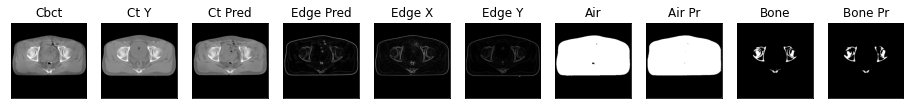

143it [00:55,  2.60it/s]

ssim score = 0.82487553358078
psnr score = 23.10438346862793
snr score = 14.388458251953125
mae error = 0.026816392317414284
air dice score = 0.9948585730655608
bone dice score = 0.8529940119782485
contour dice score = 0.4527720808982849


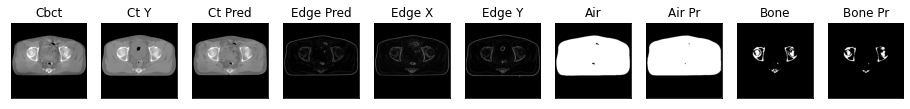

144it [00:56,  2.62it/s]

ssim score = 0.8263786435127258
psnr score = 23.251598358154297
snr score = 14.591455459594727
mae error = 0.027147309854626656
air dice score = 0.9953017599516615
bone dice score = 0.8803269118523012
contour dice score = 0.43424445390701294


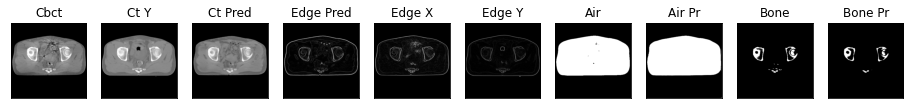

145it [00:56,  2.64it/s]

ssim score = 0.8208542466163635
psnr score = 22.75782012939453
snr score = 14.0757474899292
mae error = 0.02893301472067833
air dice score = 0.9945948404606177
bone dice score = 0.8809952038387141
contour dice score = 0.4236147105693817


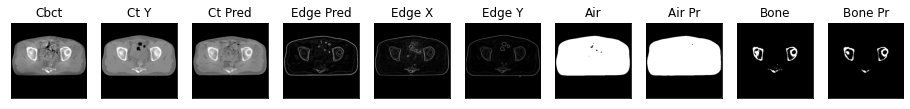

146it [00:56,  2.65it/s]

ssim score = 0.8222832083702087
psnr score = 22.4051456451416
snr score = 13.652299880981445
mae error = 0.029070407152175903
air dice score = 0.9942437399721736
bone dice score = 0.8647574904839471
contour dice score = 0.434963583946228


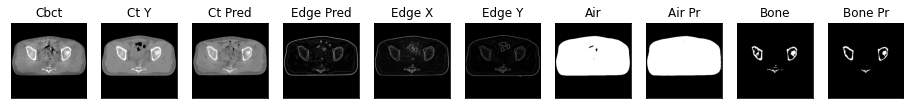

147it [00:57,  2.36it/s]

ssim score = 0.823699951171875
psnr score = 22.744041442871094
snr score = 13.94729995727539
mae error = 0.0278752651065588
air dice score = 0.9951337643645373
bone dice score = 0.8797335203387143
contour dice score = 0.4652378559112549


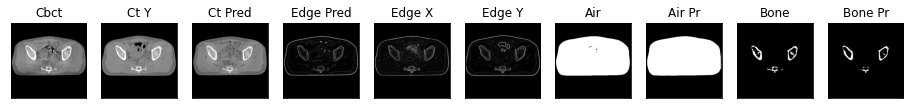

148it [00:57,  2.45it/s]

ssim score = 0.8256704807281494
psnr score = 23.116806030273438
snr score = 14.3189697265625
mae error = 0.026751680299639702
air dice score = 0.9941118519027698
bone dice score = 0.8915824915843168
contour dice score = 0.4784889817237854


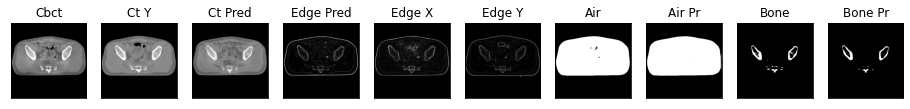

149it [00:58,  2.52it/s]

ssim score = 0.8257883787155151
psnr score = 23.34918975830078
snr score = 14.56471061706543
mae error = 0.02671382762491703
air dice score = 0.9936143627011371
bone dice score = 0.8957491514482665
contour dice score = 0.4755391776561737


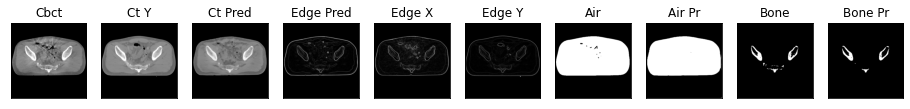

150it [00:58,  2.56it/s]

ssim score = 0.8214300870895386
psnr score = 23.212663650512695
snr score = 14.483389854431152
mae error = 0.027864621952176094
air dice score = 0.9922717870242979
bone dice score = 0.8669827105428474
contour dice score = 0.48708486557006836


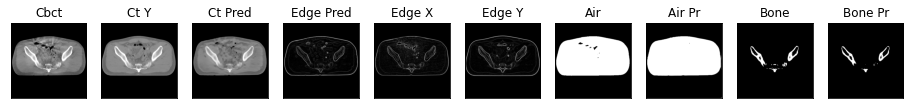

151it [00:58,  2.59it/s]

ssim score = 0.8231086134910583
psnr score = 22.812959671020508
snr score = 14.103057861328125
mae error = 0.02915031462907791
air dice score = 0.9923779314167868
bone dice score = 0.8591851322393255
contour dice score = 0.4883720874786377


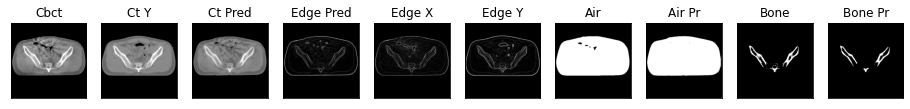

152it [00:59,  2.62it/s]

ssim score = 0.8270471096038818
psnr score = 22.686731338500977
snr score = 13.922090530395508
mae error = 0.02862492948770523
air dice score = 0.9930450186775577
bone dice score = 0.8521170610234726
contour dice score = 0.4207737147808075


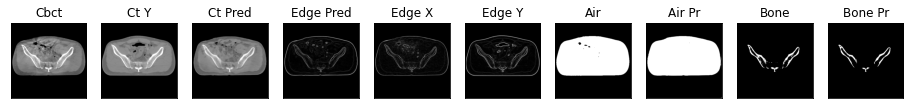

153it [00:59,  2.64it/s]

ssim score = 0.8257807493209839
psnr score = 22.7635498046875
snr score = 13.962553977966309
mae error = 0.02801317721605301
air dice score = 0.9942718813362057
bone dice score = 0.8279702970323644
contour dice score = 0.43936169147491455


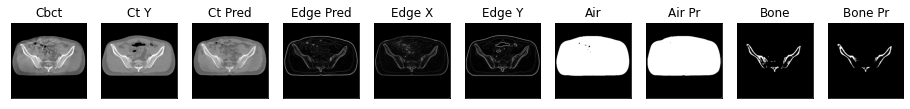

154it [00:59,  2.66it/s]

ssim score = 0.8289969563484192
psnr score = 22.841651916503906
snr score = 14.040727615356445
mae error = 0.027764439582824707
air dice score = 0.994525984203338
bone dice score = 0.8075834748187948
contour dice score = 0.3987172544002533


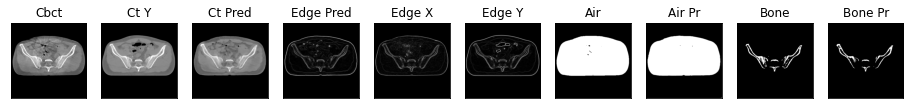

155it [01:00,  2.37it/s]

ssim score = 0.8328809142112732
psnr score = 23.154403686523438
snr score = 14.352060317993164
mae error = 0.0271860733628273
air dice score = 0.9948670377241845
bone dice score = 0.797643000865225
contour dice score = 0.42557764053344727


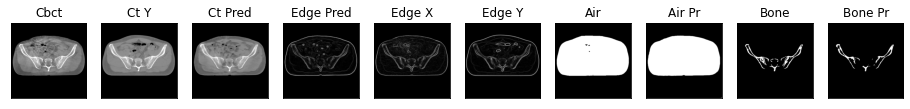

156it [01:00,  2.43it/s]

ssim score = 0.828410267829895
psnr score = 22.930561065673828
snr score = 14.133252143859863
mae error = 0.027834292501211166
air dice score = 0.9945722970039121
bone dice score = 0.8095100864580762
contour dice score = 0.3645213544368744


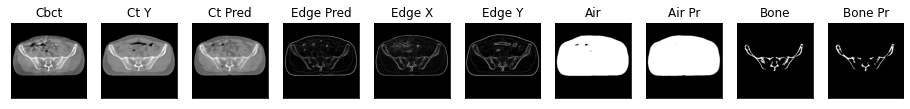

157it [01:01,  2.50it/s]

ssim score = 0.8206250667572021
psnr score = 22.444438934326172
snr score = 13.629860877990723
mae error = 0.029458343982696533
air dice score = 0.9939066622049681
bone dice score = 0.7981011719359428
contour dice score = 0.36324089765548706


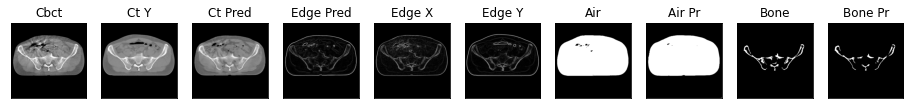

158it [01:01,  2.55it/s]

ssim score = 0.819183349609375
psnr score = 21.986591339111328
snr score = 13.153389930725098
mae error = 0.030545026063919067
air dice score = 0.9942123293028249
bone dice score = 0.7796897038112879
contour dice score = 0.38575342297554016


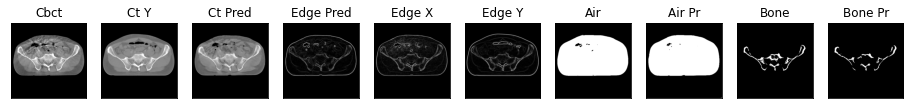

159it [01:02,  2.59it/s]

ssim score = 0.8082021474838257
psnr score = 21.50649070739746
snr score = 12.627347946166992
mae error = 0.032036829739809036
air dice score = 0.9937592727786593
bone dice score = 0.7566964285748229
contour dice score = 0.4247104227542877


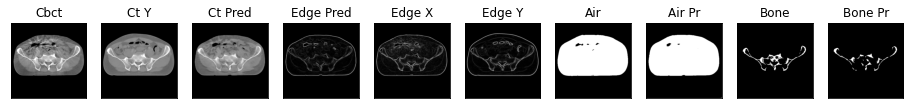

160it [01:02,  2.62it/s]

ssim score = 0.8022968769073486
psnr score = 21.551773071289062
snr score = 12.618833541870117
mae error = 0.031816136091947556
air dice score = 0.99317637418054
bone dice score = 0.8130965005327002
contour dice score = 0.3590027689933777


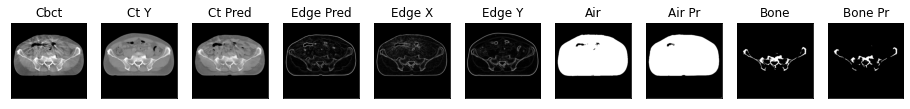

161it [01:02,  2.62it/s]

ssim score = 0.7928876876831055
psnr score = 21.112812042236328
snr score = 12.210334777832031
mae error = 0.03370759263634682
air dice score = 0.9924530093032147
bone dice score = 0.8364611260074497
contour dice score = 0.37729549407958984


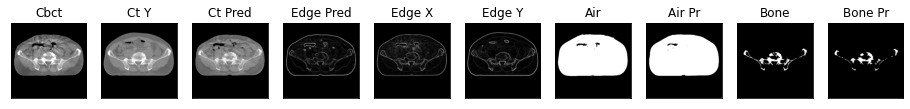

162it [01:03,  2.64it/s]

ssim score = 0.7882376313209534
psnr score = 20.811376571655273
snr score = 11.853675842285156
mae error = 0.03419836610555649
air dice score = 0.9917844284785398
bone dice score = 0.8290666666689458
contour dice score = 0.3331482410430908


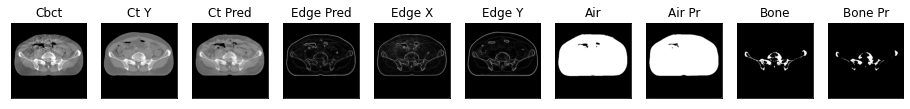

163it [01:03,  2.35it/s]

ssim score = 0.7972397804260254
psnr score = 21.47382354736328
snr score = 12.36859130859375
mae error = 0.031277526170015335
air dice score = 0.9915139198704531
bone dice score = 0.8551949822763131
contour dice score = 0.25013959407806396


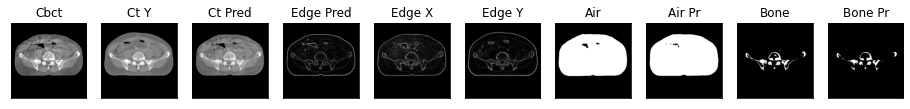

164it [01:04,  2.44it/s]

ssim score = 0.8496085405349731
psnr score = 25.332706451416016
snr score = 15.713615417480469
mae error = 0.022602535784244537
air dice score = 0.9930339475523241
bone dice score = 0.9137003841251293
contour dice score = 0.39767777919769287


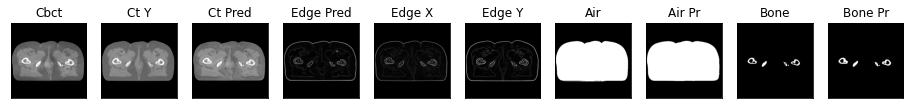

165it [01:04,  2.51it/s]

ssim score = 0.8495357036590576
psnr score = 25.601444244384766
snr score = 16.103370666503906
mae error = 0.02147980034351349
air dice score = 0.9936319702874068
bone dice score = 0.9267108167786599
contour dice score = 0.4074987769126892


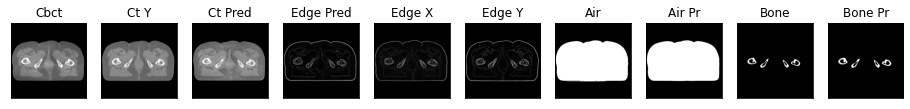

166it [01:04,  2.54it/s]

ssim score = 0.8458403944969177
psnr score = 25.728361129760742
snr score = 16.313203811645508
mae error = 0.020957056432962418
air dice score = 0.9938669922102126
bone dice score = 0.9007389654503547
contour dice score = 0.40603700280189514


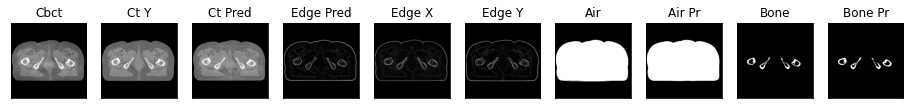

167it [01:05,  2.58it/s]

ssim score = 0.8435508012771606
psnr score = 25.6904239654541
snr score = 16.338712692260742
mae error = 0.021112659946084023
air dice score = 0.9940043538950046
bone dice score = 0.9103098387405271
contour dice score = 0.3848027288913727


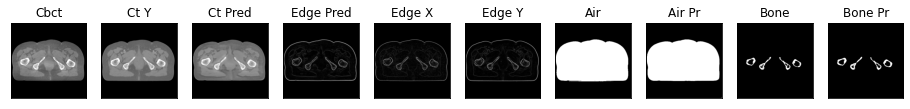

168it [01:05,  2.61it/s]

ssim score = 0.8434271812438965
psnr score = 25.54549217224121
snr score = 16.222240447998047
mae error = 0.0212800744920969
air dice score = 0.9938575115712415
bone dice score = 0.9189754312612132
contour dice score = 0.40333661437034607


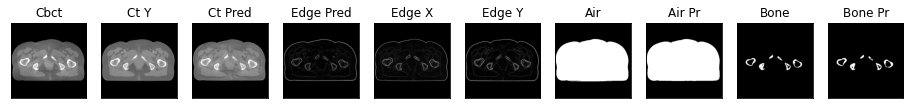

169it [01:05,  2.63it/s]

ssim score = 0.8435125350952148
psnr score = 25.417858123779297
snr score = 16.1175594329834
mae error = 0.021444758400321007
air dice score = 0.9939324227174738
bone dice score = 0.9091579141347124
contour dice score = 0.4118504226207733


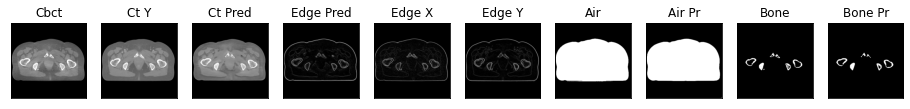

170it [01:06,  2.65it/s]

ssim score = 0.841976523399353
psnr score = 25.396102905273438
snr score = 16.127132415771484
mae error = 0.021188193932175636
air dice score = 0.9939290429990284
bone dice score = 0.9041840246349541
contour dice score = 0.4036608934402466


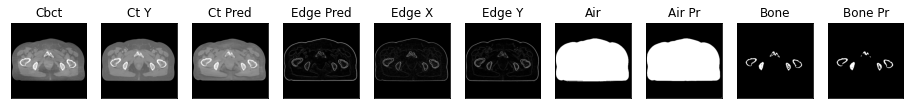

171it [01:06,  2.34it/s]

ssim score = 0.839263916015625
psnr score = 25.279264450073242
snr score = 16.058656692504883
mae error = 0.021700063720345497
air dice score = 0.9940730866533407
bone dice score = 0.8880114860034456
contour dice score = 0.4384976625442505


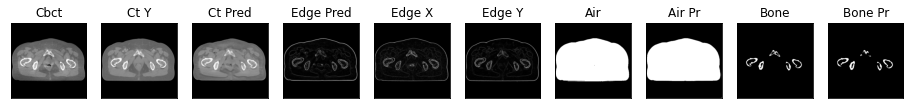

172it [01:07,  2.44it/s]

ssim score = 0.8403093814849854
psnr score = 25.04298210144043
snr score = 15.865118026733398
mae error = 0.021981047466397285
air dice score = 0.9929207090755414
bone dice score = 0.8962390866370679
contour dice score = 0.4318618178367615


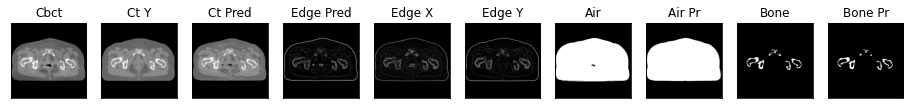

173it [01:07,  2.50it/s]

ssim score = 0.838680624961853
psnr score = 24.856216430664062
snr score = 15.766057014465332
mae error = 0.022095533087849617
air dice score = 0.9926347313969703
bone dice score = 0.8607863974516352
contour dice score = 0.41530564427375793


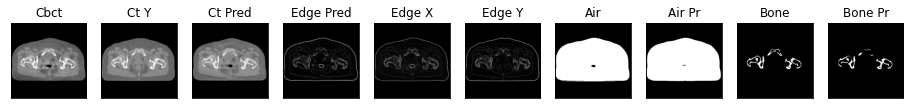

174it [01:07,  2.55it/s]

ssim score = 0.8404349088668823
psnr score = 25.75072479248047
snr score = 16.77383804321289
mae error = 0.020658977329730988
air dice score = 0.9932764232284637
bone dice score = 0.865509199276166
contour dice score = 0.4090280830860138


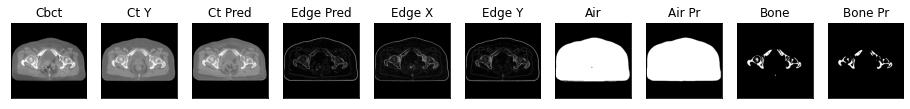

175it [01:08,  2.59it/s]

ssim score = 0.8406205177307129
psnr score = 25.537826538085938
snr score = 16.432388305664062
mae error = 0.02114206552505493
air dice score = 0.9913564826380277
bone dice score = 0.8680615597463589
contour dice score = 0.4243542551994324


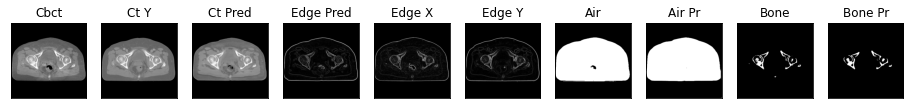

176it [01:08,  2.60it/s]

ssim score = 0.8442611694335938
psnr score = 25.410497665405273
snr score = 16.195636749267578
mae error = 0.021371323615312576
air dice score = 0.9909455162481706
bone dice score = 0.8562264150970523
contour dice score = 0.4011194109916687


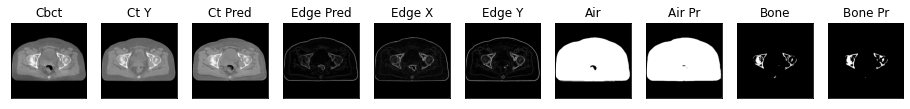

177it [01:09,  2.63it/s]

ssim score = 0.8482286334037781
psnr score = 25.1767520904541
snr score = 15.934762954711914
mae error = 0.02190595306456089
air dice score = 0.9916819519686106
bone dice score = 0.8880571623020065
contour dice score = 0.39176201820373535


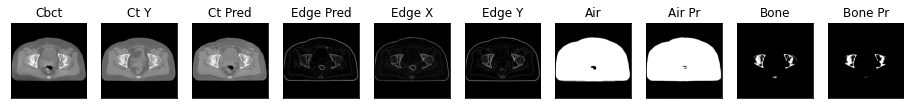

178it [01:09,  2.65it/s]

ssim score = 0.8531367182731628
psnr score = 26.05125617980957
snr score = 16.8012638092041
mae error = 0.021635526791214943
air dice score = 0.9930468386387085
bone dice score = 0.9062194724860596
contour dice score = 0.4356343150138855


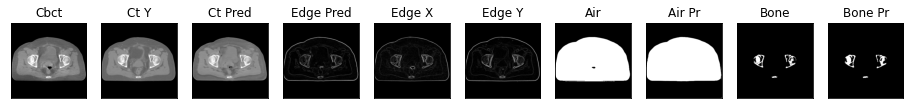

179it [01:09,  2.37it/s]

ssim score = 0.8505764603614807
psnr score = 26.338275909423828
snr score = 17.122512817382812
mae error = 0.02124159224331379
air dice score = 0.9936861535879892
bone dice score = 0.9160525472618383
contour dice score = 0.4370300769805908


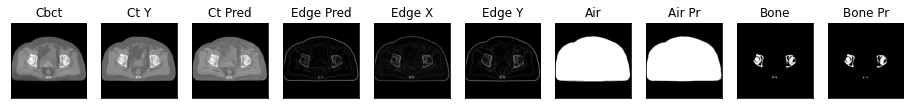

180it [01:10,  2.45it/s]

ssim score = 0.8438433408737183
psnr score = 25.730695724487305
snr score = 16.566425323486328
mae error = 0.022701038047671318
air dice score = 0.9940405575096648
bone dice score = 0.9357976653706906
contour dice score = 0.5040806531906128


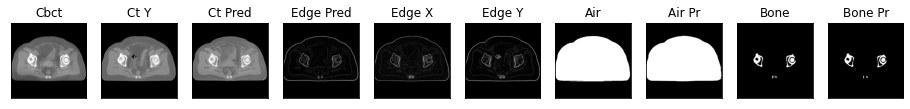

181it [01:10,  2.51it/s]

ssim score = 0.831706166267395
psnr score = 24.84723663330078
snr score = 15.720521926879883
mae error = 0.02441805601119995
air dice score = 0.9945416124613717
bone dice score = 0.9360667129962462
contour dice score = 0.4908389449119568


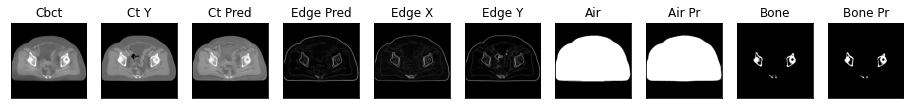

182it [01:11,  2.56it/s]

ssim score = 0.8189854025840759
psnr score = 23.56428337097168
snr score = 14.365133285522461
mae error = 0.026475505903363228
air dice score = 0.9945767249976131
bone dice score = 0.9117964201011043
contour dice score = 0.49609375


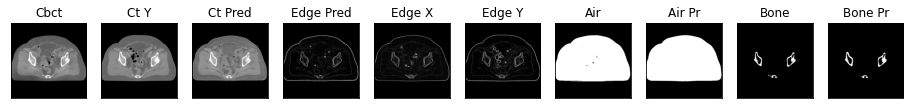

183it [01:11,  2.59it/s]

ssim score = 0.8109526038169861
psnr score = 23.3675594329834
snr score = 14.15041732788086
mae error = 0.027962082996964455
air dice score = 0.9936329918157882
bone dice score = 0.9200000000017204
contour dice score = 0.5105963349342346


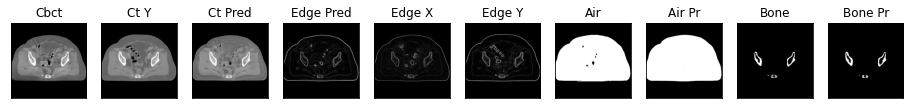

184it [01:11,  2.62it/s]

ssim score = 0.8082059621810913
psnr score = 23.75552749633789
snr score = 14.60329818725586
mae error = 0.027897682040929794
air dice score = 0.9945207687039237
bone dice score = 0.922397476342326
contour dice score = 0.519980251789093


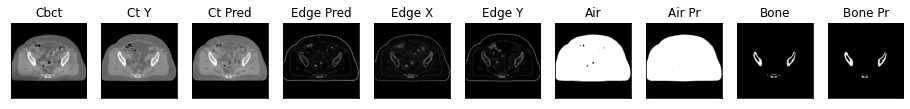

185it [01:12,  2.64it/s]

ssim score = 0.8030827641487122
psnr score = 23.724159240722656
snr score = 14.627022743225098
mae error = 0.028293456882238388
air dice score = 0.9947562452586644
bone dice score = 0.9233576642349752
contour dice score = 0.5009940266609192


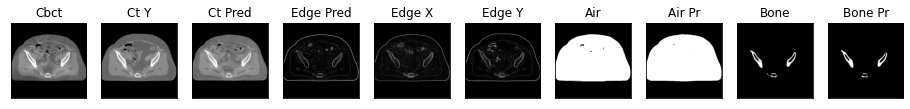

186it [01:12,  2.65it/s]

ssim score = 0.7995191812515259
psnr score = 23.221004486083984
snr score = 14.188299179077148
mae error = 0.029762791469693184
air dice score = 0.9949438017073767
bone dice score = 0.9090909090923194
contour dice score = 0.5083414912223816


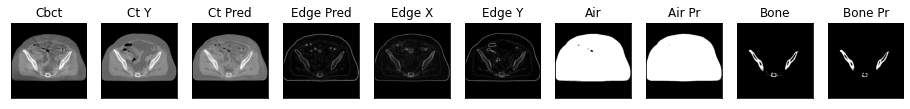

187it [01:13,  2.36it/s]

ssim score = 0.8003423810005188
psnr score = 23.20199966430664
snr score = 14.24215316772461
mae error = 0.030098045244812965
air dice score = 0.995064036768026
bone dice score = 0.8852744699406727
contour dice score = 0.5423228144645691


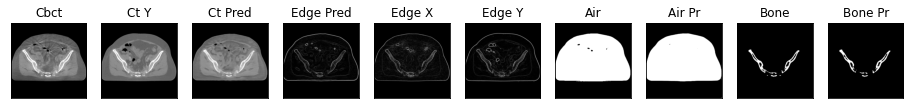

188it [01:13,  2.43it/s]

ssim score = 0.7999768853187561
psnr score = 23.21084976196289
snr score = 14.246715545654297
mae error = 0.03065148927271366
air dice score = 0.9946954762398872
bone dice score = 0.8693997071761435
contour dice score = 0.5158459544181824


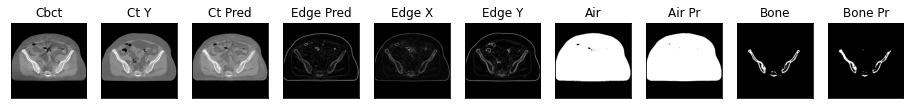

189it [01:13,  2.48it/s]

ssim score = 0.7972420454025269
psnr score = 23.02349281311035
snr score = 14.037178039550781
mae error = 0.0315374992787838
air dice score = 0.9952634048214327
bone dice score = 0.8578901482147938
contour dice score = 0.550654411315918


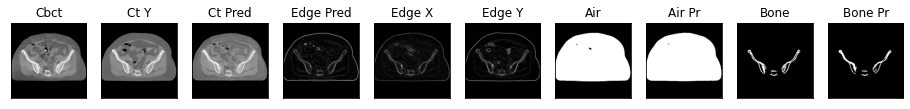

190it [01:14,  2.54it/s]

ssim score = 0.8026612997055054
psnr score = 23.53155517578125
snr score = 14.556876182556152
mae error = 0.030844148248434067
air dice score = 0.99570388689877
bone dice score = 0.8709531697053011
contour dice score = 0.5452793836593628


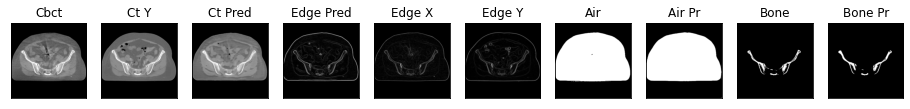

191it [01:14,  2.55it/s]


In [46]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [47]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [48]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [49]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:09, 19.61it/s]


(0.8236361096042613,
 23.489397917742505,
 14.493670069110332,
 0.027373285447271706,
 0.9932059920980022,
 0.8560217090187984,
 0.4001383571568584,
 0.5052356020942408,
 0.5026178010471204)

In [50]:
# import torchvision.models as models
# models.vgg16(pretrained=True)